In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import dataclasses as dt

In [3]:
import os
import shutil
from datetime import datetime
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import aps.ai.autoalignment.beamline28IDB.optimization.configs as configs
import aps.ai.autoalignment.beamline28IDB.optimization.movers as movers
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
from aps.ai.autoalignment.beamline28IDB.facade.focusing_optics_factory import (
    ExecutionMode,
    focusing_optics_factory_method,
)
from aps.ai.autoalignment.beamline28IDB.optimization.optuna_botorch import OptunaOptimizer
from aps.ai.autoalignment.beamline28IDB.simulation.facade.focusing_optics_interface import (
    Layout,
    get_default_input_features,
)
from aps.ai.autoalignment.common.simulation.facade.parameters import Implementors
from aps.ai.autoalignment.common.util import clean_up
from aps.ai.autoalignment.common.util.common import AspectRatio, ColorMap, PlotMode
from aps.ai.autoalignment.common.util.shadow.common import (
    EmptyBeamException,
    HybridFailureException,
    PreProcessorFiles,
    load_shadow_beam,
)
from aps.ai.autoalignment.common.util.wrappers import load_beam
from epics import ca

ca.finalize_libca()

%matplotlib inline

28-ID - VKB Pitch Motor Resolution: 2e-05 deg


**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.


In [4]:
DEFAULT_RANDOM_SEED = np.random.randint(100000)
DEFAULT_RANDOM_SEED

38449

In [22]:
class OptimizationParameters:
    def __init__(self):
        self.move_motors_ranges = configs.DEFAULT_MOVEMENT_RANGES

        self.params = {
            "sum_intensity_soft_constraint": 7e3,
            "sum_intensity_hard_constraint": 6.5e3,
            #            "centroid_sigma_loss_threshold_dependency": CentroidSigmaLossThresholdDependency.FULLY_DYNAMIC,
            #            "centroid_sigma_loss_hard_thresholds": [0.01, 0.03],
            "loss_parameters": ["kl_divergence", "negative_log_peak_intensity"],
            "multi_objective_optimization": True,
            "n_pitch_trans_motor_trials": 50,
            "n_all_motor_trials": 100,
            "moo_thresholds": {"fwhm": 0.02},
        }

In [23]:
def setup_work_dir():
    root_dir = Path(aps.__path__[0]).parents[0]
    work_dir = root_dir / "work_directory/28-ID"
    os.chdir(work_dir)

    new_dir = work_dir / f"work_dir_{DEFAULT_RANDOM_SEED}"
    new_dir.mkdir(exist_ok=True)

    files = work_dir.glob("*")
    for f in files:
        if f.is_file():
            shutil.copy2(f, new_dir)
    os.chdir(new_dir)

In [24]:
def print_beam_attributes(cp, loss_parameters, hist, dw, title):
    loss_dw_functions = {
        "peak_distance": opt_common._get_peak_distance_from_dw,
        "centroid": opt_common._get_centroid_distance_from_dw,
        "sigma": opt_common._get_sigma_from_dw,
        "fwhm": opt_common._get_fwhm_from_dw,
        "negative_log_peak_intensity": lambda dw: -np.log(opt_common._get_peak_intensity_from_dw(dw)),
    }
    loss_hist_functions = {
        "log_weighted_sum_intensity": lambda hist: np.log(
            opt_common._get_weighted_sum_intensity_from_hist(cp, hist, 2)
        ),
        "kl_divergence": lambda hist: opt_common._get_kl_divergence_with_gaussian_from_hist(cp, hist),
    }

    attribs = {}
    for ltype in loss_parameters:
        if ltype in loss_dw_functions:
            loss = loss_dw_functions[ltype](dw)
        if ltype in loss_hist_functions:
            loss = loss_hist_functions[ltype](hist)
        attribs[ltype] = loss
        print(f"{title} system {ltype}: {loss:4.3e}")
    return attribs

In [25]:
detector_x = 2160 * 0.65 * 1e-3
detector_y = 2560 * 0.65 * 1e-3
cp = opt_common.CalculationParameters(
    xrange=[-detector_x / 2, detector_x / 2],
    yrange=[-detector_y / 2, detector_y / 2],
    nbins_h=1024,
    nbins_v=1024,
    use_denoised=False,
    random_seed=111,
    add_noise=True,
    calculate_over_noise=False,
    noise_threshold=1.5,
    implementor=Implementors.SHADOW,
    percentage_fluctuation=50,
    noise=0.5,
)

xrange_plot = [x / 5 for x in cp.xrange]
yrange_plot = [y / 5 for y in cp.yrange]

ppm = opt_common.PlotParameters(
    xrange=xrange_plot, yrange=yrange_plot, nbins_h=cp.nbins_h // 5, nbins_v=cp.nbins_v // 5
)  # xrange=xrange_plot, yrange=yrange_plot)#, )

In [26]:
setup_work_dir()
clean_up()

print(cp)

CalculationParameters(execution_mode=0, implementor=0, xrange=[-0.7020000000000001, 0.7020000000000001], yrange=[-0.8320000000000001, 0.8320000000000001], nbins_h=1024, nbins_v=1024, do_gaussian_fit=False, use_denoised=False, from_raw_image=True, random_seed=111, add_noise=True, noise=0.5, percentage_fluctuation=50, calculate_over_noise=False, noise_threshold=1.5, reference_h=0.0, reference_v=0.0, save_images=False, every_n_images=5)


In [27]:
opt_params = OptimizationParameters()


print("Motors and movement ranges")
print(opt_params.move_motors_ranges)

print("Optimization parameters")
print(opt_params.params)

Motors and movement ranges
{'hb_1': [-25, 25], 'hb_2': [-25, 25], 'hb_pitch': [-0.002, 0.002], 'hb_trans': [-0.03, 0.03], 'vb_bender': [-20.0, 20.0], 'vb_pitch': [-0.002, 0.002], 'vb_trans': [-0.03, 0.03]}
Optimization parameters
{'sum_intensity_soft_constraint': 7000.0, 'sum_intensity_hard_constraint': 6500.0, 'loss_parameters': ['kl_divergence', 'negative_log_peak_intensity'], 'multi_objective_optimization': True, 'n_pitch_trans_motor_trials': 50, 'n_all_motor_trials': 100, 'moo_thresholds': {'fwhm': 0.02}}


In [28]:
input_beam_path = "primary_optics_system_beam.dat"

clean_up()

# Initializing the focused beam from simulation
input_features = get_default_input_features(layout=Layout.AUTO_FOCUSING)
input_beam = load_shadow_beam(input_beam_path)
focusing_system = focusing_optics_factory_method(
    execution_mode=ExecutionMode.SIMULATION,
    implementor=Implementors.SHADOW,
    bender=True,
)

focusing_system.initialize(
    input_photon_beam=input_beam,
    rewrite_preprocessor_files=PreProcessorFiles.NO,
    layout=Layout.AUTO_FOCUSING,
    input_features=input_features,
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


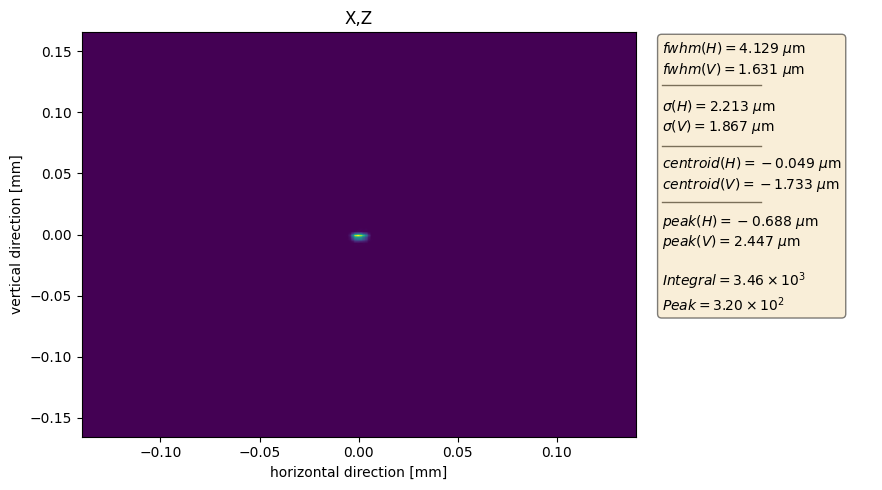

In [29]:
beam, hist, dw = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam, ppm=ppm)

In [30]:
attribs_focus = print_beam_attributes(cp, opt_params.params["loss_parameters"], hist, dw, "Focused beam")

Focused beam system kl_divergence: 1.331e+00
Focused beam system negative_log_peak_intensity: -5.761e+00


In [31]:
mots = list(opt_params.move_motors_ranges.keys())
initial_absolute_positions = {k: movers.get_absolute_positions(focusing_system, k)[0] for k in mots}
print("Focused absolute position are", initial_absolute_positions)

Focused absolute position are {'hb_1': -168.0, 'hb_2': -161.0, 'hb_pitch': 0.17188733853924987, 'hb_trans': 0.0, 'vb_bender': 419.0, 'vb_pitch': 0.17188733853924987, 'vb_trans': 0.0}


In [32]:
# Adding random perturbation to the motor values
initial_movement, focusing_system, (beam_init, hist_init, dw_init) = opt_common.get_random_init(
    focusing_system=focusing_system,
    motor_types_and_ranges=opt_params.move_motors_ranges,
    intensity_sum_threshold=opt_params.params["sum_intensity_hard_constraint"],
    cp=cp,
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.
Random initialization is (ABSOLUTE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [-192.9, -146.2, 0.17228733853924988, 0.0476, 418.09999999999997, 0.17135733853924986, 0.0152]
Random initialization is (RELATIVE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [-24.89004974693685, 14.838227301485695, -0.00039918783718302284, 0.023846729803335888, -0.9472558468388854, -0.0005267582265266956, 0.015150898819732188]


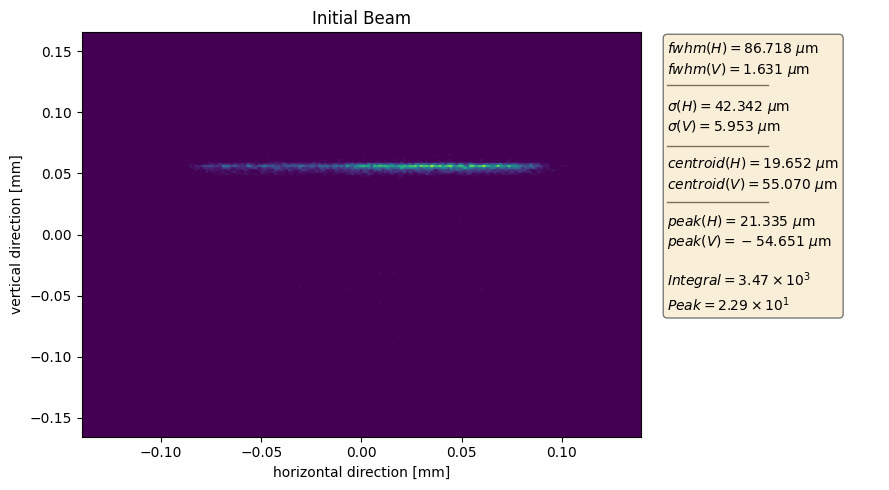

Perturbed beam system kl_divergence: 1.342e+00
Perturbed beam system negative_log_peak_intensity: -3.063e+00


In [33]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert,
    ppm=ppm,
    title="Initial Beam",
)
attribs_init = print_beam_attributes(cp, opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

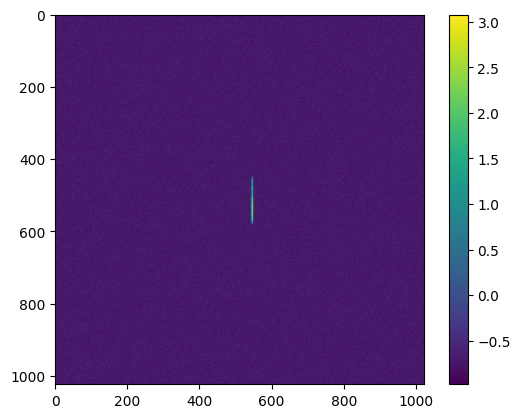

In [34]:
plt.imshow(np.log(hist_pert.data_2D))
plt.colorbar()

In [35]:
perturbed_positions = initial_movement + np.array(list(initial_absolute_positions.values()))

#### KL Divergence without remomving noise

In [29]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement="absolute")

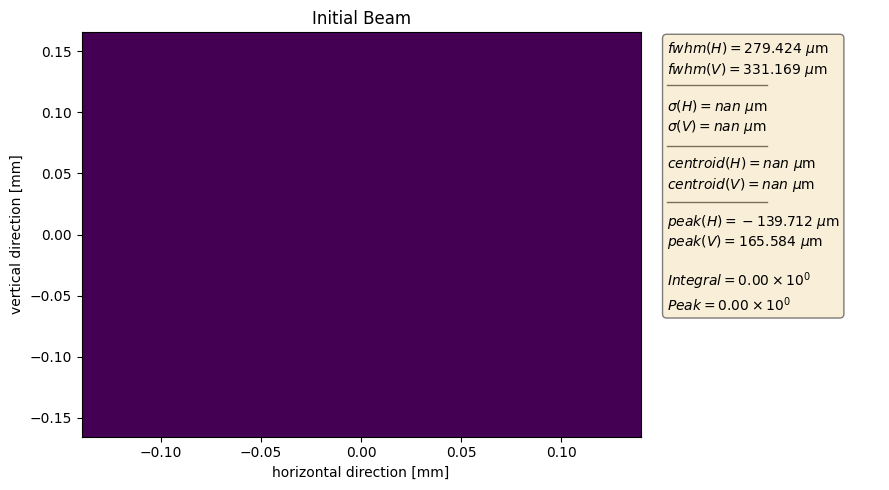

In [30]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam_pert, title="Initial Beam", ppm=ppm)

In [31]:
attribs_init = print_beam_attributes(cp, opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system kl_divergence: 1.342e+00
Perturbed beam system negative_log_peak_intensity: -3.829e+00


In [40]:
opt_params = OptimizationParameters()

In [41]:
# Now the optimization
opt_trial = OptunaOptimizer(
    calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    reference_parameters_h_v={"fwhm": (5e-3, 5e-3)},
)

In [42]:
moo_thresholds = None
if opt_params.params["multi_objective_optimization"]:
    moo_thresholds = opt_params.params["moo_thresholds"]
    for ltype in opt_params.params["loss_parameters"]:
        if ltype not in moo_thresholds:
            moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [43]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds,
)

[I 2023-05-22 15:36:01,876] A new study created in memory with name: no-name-12b5508a-e9b4-4ec4-a7a9-5511bddd007e


In [44]:
opt_trial.trials(50)  # , trial_motor_types=['hb_pitch', 'hb_trans', 'vb_pitch', 'vb_trans'])

/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(
[I 2023-05-22 15:36:08,817] Trial 0 finished with values: [1.3416151278847717, -3.8272319276673685] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': 0.0, 'vb_bender': 0.0, 'vb_pitch': 0.0, 'vb_trans': 0.0}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:36:16,202] Trial 1 finished with values: [1.3415850260346904, -2.2794153967043123] and parameters: {'hb_1': 6.0, 'hb_2': -17.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': 0.016100000000000003, 'vb_bender': -8.0, 'vb_pitch': -0.00142, 'vb_trans': -0.0287}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:36:23,307] Trial 2 finished with values: [1.3416087512686647, -2.262569725407809] and parameters: {'hb_1': -4.0, 'hb_2': -13.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': 0.029400000000000003, 'vb_bender': -11.0, 'vb_pitch': -0.00168, 'vb_trans': 0.010100000000000005}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:36:31,230] Trial 3 finished with values: [1.3416012981272296, -2.0087878560736194] and parameters: {'hb_1': 6.0, 'hb_2': -12.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.022899999999999997, 'vb_bender': -17.0, 'vb_pitch': 0.0016000000000000003, 'vb_trans': 0.017600000000000005}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:36:38,827] Trial 4 finished with values: [1.3416280344822322, -2.1599926231352113] and parameters: {'hb_1': 17.0, 'hb_2': 16.0, 'hb_pitch': 0.0019, 'hb_trans': 0.0046, 'vb_bender': 13.0, 'vb_pitch': -0.00031999999999999997, 'vb_trans': -0.028399999999999998}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:36:45,665] Trial 5 finished with values: [1.341603933973071, -3.2667503063230945] and parameters: {'hb_1': -2.0, 'hb_2': -20.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.011800000000000005, 'vb_bender': 3.0, 'vb_pitch': -0.00092, 'vb_trans': 0.0299}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:36:52,793] Trial 6 finished with values: [1.341617991042234, -3.628128471758425] and parameters: {'hb_1': -18.0, 'hb_2': 6.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': -0.005699999999999997, 'vb_bender': 9.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': -0.005999999999999998}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:36:59,619] Trial 7 finished with values: [1.3416059859702798, -2.6618799687903105] and parameters: {'hb_1': -9.0, 'hb_2': 23.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.018800000000000004, 'vb_bender': -19.0, 'vb_pitch': 0.0017600000000000003, 'vb_trans': 0.027000000000000003}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:37:06,805] Trial 8 finished with values: [1.3416088134524449, -3.025009473378371] and parameters: {'hb_1': 16.0, 'hb_2': -1.0, 'hb_pitch': 0.0018, 'hb_trans': -0.0049999999999999975, 'vb_bender': -7.0, 'vb_pitch': -0.00194, 'vb_trans': -0.0278}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:37:14,070] Trial 9 finished with values: [1.3416146825128352, -2.779989228618055] and parameters: {'hb_1': -23.0, 'hb_2': -19.0, 'hb_pitch': -0.0019, 'hb_trans': -0.0165, 'vb_bender': 2.0, 'vb_pitch': -0.0013, 'vb_trans': -0.019299999999999998}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:37:22,872] Trial 10 finished with values: [1.3416107166069893, -2.8262891228691456] and parameters: {'hb_1': 11.0, 'hb_2': -13.0, 'hb_pitch': 0.0002999999999999999, 'hb_trans': 0.014400000000000003, 'vb_bender': 1.0, 'vb_pitch': -0.00112, 'vb_trans': -0.0184}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:37:32,489] Trial 11 finished with values: [1.3416126785911442, -4.652996491337063] and parameters: {'hb_1': -11.0, 'hb_2': -10.0, 'hb_pitch': 0.0006000000000000003, 'hb_trans': 0.005600000000000001, 'vb_bender': -2.0, 'vb_pitch': -0.00066, 'vb_trans': 0.026900000000000007}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:37:41,505] Trial 12 finished with values: [1.3416134170792418, -3.0751302588435916] and parameters: {'hb_1': -18.0, 'hb_2': -11.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': 0.0097, 'vb_bender': 4.0, 'vb_pitch': -0.0012000000000000001, 'vb_trans': 0.029200000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:37:50,810] Trial 13 finished with values: [1.3415772833730946, -1.2691305226829939] and parameters: {'hb_1': 10.0, 'hb_2': -3.0, 'hb_pitch': 0.001, 'hb_trans': 0.0007000000000000027, 'vb_bender': -4.0, 'vb_pitch': -0.0002999999999999999, 'vb_trans': 0.025800000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03,

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:38:00,796] Trial 14 finished with values: [1.3415875361959029, -2.7228406351762664] and parameters: {'hb_1': -3.0, 'hb_2': -3.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': 0.014900000000000004, 'vb_bender': -8.0, 'vb_pitch': 0.0, 'vb_trans': 0.028600000000000007}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:38:10,293] Trial 15 finished with values: [1.3416106022346377, -3.6575568405114485] and parameters: {'hb_1': 2.0, 'hb_2': -1.0, 'hb_pitch': 0.0017000000000000001, 'hb_trans': 0.009900000000000006, 'vb_bender': -4.0, 'vb_pitch': 2.0000000000000052e-05, 'vb_trans': 0.025800000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specif

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:38:20,153] Trial 16 finished with values: [1.3415947929310856, -3.4387208482911618] and parameters: {'hb_1': -11.0, 'hb_2': -9.0, 'hb_pitch': 0.0006000000000000003, 'hb_trans': 0.0022000000000000006, 'vb_bender': -11.0, 'vb_pitch': -2.0000000000000052e-05, 'vb_trans': 0.022000000000000006}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is s

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:38:29,639] Trial 17 finished with values: [1.3415850725067877, -2.5987690857280494] and parameters: {'hb_1': -1.0, 'hb_2': 1.0, 'hb_pitch': 0.0002000000000000001, 'hb_trans': 0.004500000000000004, 'vb_bender': -13.0, 'vb_pitch': -0.00015999999999999999, 'vb_trans': 0.023900000000000005}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is spec

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:38:40,973] Trial 18 finished with values: [1.3416015814232645, -3.02053108128998] and parameters: {'hb_1': -7.0, 'hb_2': -3.0, 'hb_pitch': 0.0, 'hb_trans': 0.006400000000000003, 'vb_bender': -10.0, 'vb_pitch': -2.0000000000000052e-05, 'vb_trans': 0.0216}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.02990000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:38:51,706] Trial 19 finished with values: [1.3415910125242665, -2.0565751589004075] and parameters: {'hb_1': 3.0, 'hb_2': -14.0, 'hb_pitch': 0.0006000000000000003, 'hb_trans': 0.011300000000000004, 'vb_bender': -16.0, 'vb_pitch': 0.0002000000000000001, 'vb_trans': 0.025400000000000006}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is speci

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:39:02,034] Trial 20 finished with values: [1.3416332320422797, -3.846458482374577] and parameters: {'hb_1': -7.0, 'hb_2': -17.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': 0.0050000000000000044, 'vb_bender': -2.0, 'vb_pitch': 0.00013999999999999993, 'vb_trans': 0.017100000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is spec

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:39:11,975] Trial 21 finished with values: [1.3416056629267084, -3.5465028939865646] and parameters: {'hb_1': -13.0, 'hb_2': -7.0, 'hb_pitch': 0.0005, 'hb_trans': -0.004899999999999998, 'vb_bender': -8.0, 'vb_pitch': -0.00021999999999999993, 'vb_trans': 0.0291}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.02990000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:39:21,706] Trial 22 finished with values: [1.3416353325997579, -2.9812431172883733] and parameters: {'hb_1': -9.0, 'hb_2': -2.0, 'hb_pitch': 0.0007000000000000001, 'hb_trans': -0.004099999999999996, 'vb_bender': -14.0, 'vb_pitch': -0.00056, 'vb_trans': 0.020100000000000007}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:39:31,961] Trial 23 finished with values: [1.3416176001134046, -4.587748881107863] and parameters: {'hb_1': -6.0, 'hb_2': 6.0, 'hb_pitch': -0.0013, 'hb_trans': 0.007900000000000004, 'vb_bender': -4.0, 'vb_pitch': -9.999999999999983e-05, 'vb_trans': 0.028800000000000006}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:39:42,545] Trial 24 finished with values: [1.3416074400161557, -4.54547423000716] and parameters: {'hb_1': -4.0, 'hb_2': 5.0, 'hb_pitch': 0.0002999999999999999, 'hb_trans': 0.0068000000000000005, 'vb_bender': -5.0, 'vb_pitch': 0.0010600000000000002, 'vb_trans': 0.024400000000000005}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specifie

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:39:51,849] Trial 25 finished with values: [1.3415858982001665, -4.005371554627944] and parameters: {'hb_1': -7.0, 'hb_2': -7.0, 'hb_pitch': -0.0016, 'hb_trans': 0.0021000000000000046, 'vb_bender': 0.0, 'vb_pitch': 0.0010600000000000002, 'vb_trans': 0.023000000000000007}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:40:02,474] Trial 26 finished with values: [1.3416050102235526, -3.967893511219511] and parameters: {'hb_1': -1.0, 'hb_2': 9.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.006100000000000001, 'vb_bender': -1.0, 'vb_pitch': 0.0011000000000000003, 'vb_trans': 0.029700000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specifie

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:40:13,609] Trial 27 finished with values: [1.3415956812198049, -2.7612100024582653] and parameters: {'hb_1': -1.0, 'hb_2': -10.0, 'hb_pitch': -0.0010999999999999998, 'hb_trans': 0.0019000000000000059, 'vb_bender': -7.0, 'vb_pitch': 0.0018800000000000002, 'vb_trans': 0.027300000000000005}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is spe

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:40:25,492] Trial 28 finished with values: [1.341615906453714, -4.217088031664808] and parameters: {'hb_1': -1.0, 'hb_2': 4.0, 'hb_pitch': -0.0009, 'hb_trans': 0.010700000000000001, 'vb_bender': -1.0, 'vb_pitch': 0.0017400000000000002, 'vb_trans': 0.028700000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:40:36,409] Trial 29 finished with values: [1.3415936900259418, -3.937511209917033] and parameters: {'hb_1': -7.0, 'hb_2': -7.0, 'hb_pitch': -0.0005, 'hb_trans': 0.0031000000000000055, 'vb_bender': -3.0, 'vb_pitch': 0.0015800000000000002, 'vb_trans': 0.027200000000000002}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03,

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:40:47,628] Trial 30 finished with values: [1.341624667699771, -3.98742670578107] and parameters: {'hb_1': -8.0, 'hb_2': 4.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': 0.0040999999999999995, 'vb_bender': -4.0, 'vb_pitch': -0.00118, 'vb_trans': 0.028300000000000006}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03,

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:40:59,614] Trial 31 finished with values: [1.3416042441930065, -4.446407199195232] and parameters: {'hb_1': -10.0, 'hb_2': -17.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': 0.013900000000000003, 'vb_bender': -3.0, 'vb_pitch': 0.0005400000000000001, 'vb_trans': 0.029300000000000007}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is spec

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:41:11,194] Trial 32 finished with values: [1.3416142188026103, -3.4635252923827644] and parameters: {'hb_1': -2.0, 'hb_2': -4.0, 'hb_pitch': -0.0014, 'hb_trans': 0.009500000000000001, 'vb_bender': 1.0, 'vb_pitch': 0.00152, 'vb_trans': 0.0165}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and st

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:41:22,580] Trial 33 finished with values: [1.341620598746213, -4.430447029769917] and parameters: {'hb_1': -5.0, 'hb_2': 8.0, 'hb_pitch': 0.0, 'hb_trans': -0.003599999999999999, 'vb_bender': -2.0, 'vb_pitch': 0.0006000000000000003, 'vb_trans': 0.026400000000000007}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:41:32,336] Trial 34 finished with values: [1.3416131933288162, -4.336966128455391] and parameters: {'hb_1': -12.0, 'hb_2': -3.0, 'hb_pitch': -0.0018, 'hb_trans': 0.0143, 'vb_bender': -2.0, 'vb_pitch': 0.0003600000000000001, 'vb_trans': 0.019700000000000002}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.02990000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:41:44,028] Trial 35 finished with values: [1.3416056474420535, -4.035371908341394] and parameters: {'hb_1': -14.0, 'hb_2': -14.0, 'hb_pitch': -0.0014, 'hb_trans': 0.0032000000000000015, 'vb_bender': 3.0, 'vb_pitch': 0.00116, 'vb_trans': 0.029200000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.0299000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:41:56,184] Trial 36 finished with values: [1.3402590756520756, -3.381965609588921] and parameters: {'hb_1': -13.0, 'hb_2': -17.0, 'hb_pitch': -0.0018, 'hb_trans': 0.0009000000000000015, 'vb_bender': -2.0, 'vb_pitch': 0.0009200000000000002, 'vb_trans': 0.026500000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:42:05,329] Trial 37 finished with values: [1.3416078576601231, -4.621616952387998] and parameters: {'hb_1': -10.0, 'hb_2': -15.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': 0.007600000000000003, 'vb_bender': 0.0, 'vb_pitch': 0.00034, 'vb_trans': 0.028100000000000007}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:42:13,945] Trial 38 finished with values: [1.3415968966454093, -4.939639812741813] and parameters: {'hb_1': -11.0, 'hb_2': -16.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': 0.0155, 'vb_bender': 1.0, 'vb_pitch': 0.0006400000000000004, 'vb_trans': 0.0262}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.0299000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:42:26,192] Trial 39 finished with values: [1.3416205753950086, -4.654746464075492] and parameters: {'hb_1': -11.0, 'hb_2': -21.0, 'hb_pitch': -0.0005, 'hb_trans': 0.009900000000000006, 'vb_bender': 2.0, 'vb_pitch': -0.0005999999999999998, 'vb_trans': 0.017100000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:42:39,984] Trial 40 finished with values: [1.3416102393613303, -4.499333728591219] and parameters: {'hb_1': -10.0, 'hb_2': -21.0, 'hb_pitch': -0.002, 'hb_trans': 0.0058, 'vb_bender': 3.0, 'vb_pitch': 0.0007800000000000003, 'vb_trans': 0.023600000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:42:52,033] Trial 41 finished with values: [1.3415950075024405, -4.391330756685709] and parameters: {'hb_1': -10.0, 'hb_2': -14.0, 'hb_pitch': -0.0009, 'hb_trans': 0.013700000000000004, 'vb_bender': 2.0, 'vb_pitch': 0.00018000000000000004, 'vb_trans': 0.027100000000000006}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:43:05,129] Trial 42 finished with values: [1.3416255216169979, -4.502132662097629] and parameters: {'hb_1': -10.0, 'hb_2': -17.0, 'hb_pitch': -0.0016, 'hb_trans': 0.011300000000000004, 'vb_bender': 1.0, 'vb_pitch': -0.0006199999999999999, 'vb_trans': 0.012200000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:43:17,164] Trial 43 finished with values: [1.341602479733225, -3.7752261755550083] and parameters: {'hb_1': -9.0, 'hb_2': -23.0, 'hb_pitch': -0.0016, 'hb_trans': 0.0075, 'vb_bender': 4.0, 'vb_pitch': 0.0016600000000000005, 'vb_trans': 0.0296}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and st

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:43:32,133] Trial 44 finished with values: [1.3415962065875418, -3.8801102777479173] and parameters: {'hb_1': -13.0, 'hb_2': -24.0, 'hb_pitch': -0.002, 'hb_trans': 0.008600000000000003, 'vb_bender': -3.0, 'vb_pitch': -0.00098, 'vb_trans': 0.023200000000000005}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:43:46,485] Trial 45 finished with values: [1.3416124116154013, -3.7252313707608526] and parameters: {'hb_1': -7.0, 'hb_2': 13.0, 'hb_pitch': -0.0009, 'hb_trans': 0.0023000000000000034, 'vb_bender': -5.0, 'vb_pitch': 0.00168, 'vb_trans': 0.016300000000000002}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.0299000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:43:59,050] Trial 46 finished with values: [1.3416044112142973, -4.006916276181967] and parameters: {'hb_1': -7.0, 'hb_2': -13.0, 'hb_pitch': -0.0010999999999999998, 'hb_trans': 0.004400000000000001, 'vb_bender': -1.0, 'vb_pitch': 0.0005800000000000002, 'vb_trans': 0.014900000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is speci

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:44:11,203] Trial 47 finished with values: [1.3415955684922132, -3.9027909234393765] and parameters: {'hb_1': -10.0, 'hb_2': -9.0, 'hb_pitch': 0.0009000000000000002, 'hb_trans': 0.0022000000000000006, 'vb_bender': 1.0, 'vb_pitch': -0.0016, 'vb_trans': 0.018000000000000002}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:44:21,922] Trial 48 finished with values: [1.3415890920860931, -4.051377760930098] and parameters: {'hb_1': -8.0, 'hb_2': 13.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': 0.004800000000000006, 'vb_bender': -2.0, 'vb_pitch': -0.00042, 'vb_trans': 0.025900000000000006}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 15:44:36,297] Trial 49 finished with values: [1.3415968514313004, -3.7062361803162878] and parameters: {'hb_1': -3.0, 'hb_2': 9.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': 0.016100000000000003, 'vb_bender': 0.0, 'vb_pitch': 0.001, 'vb_trans': 0.024200000000000006}. 


In [45]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs["ws"])

nan 207117.0589657892
nan 207116.52953158497
nan 207119.87088634717
nan 207187.77299537367
nan 207118.90432275395


/tmp/ipykernel_758275/261318559.py:4: RuntimeWarning: invalid value encountered in log
  print(np.log(vals).sum(), t.user_attrs["ws"])


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.
[1.3415858982001665, -4.005371554627944]


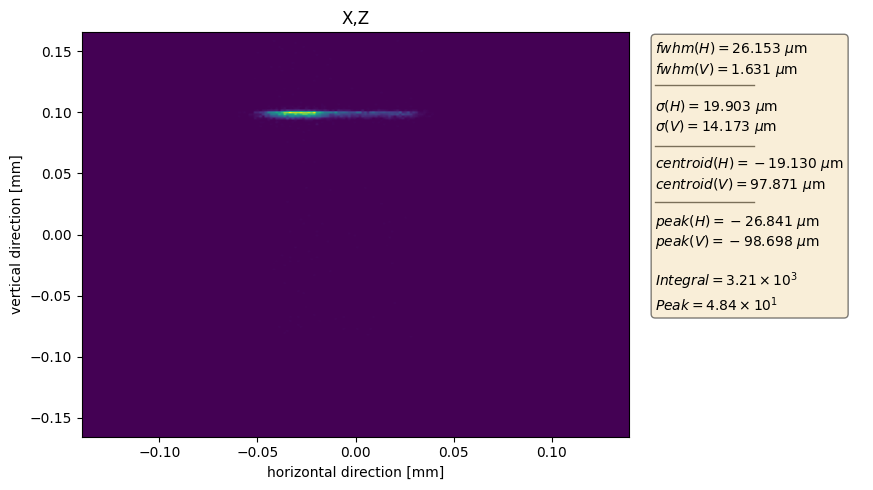

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.
[1.3402590756520756, -3.381965609588921]


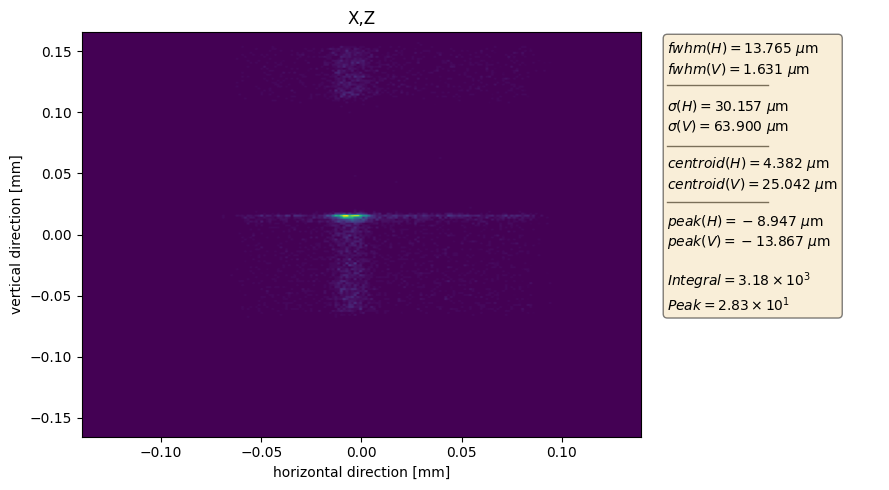

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.
[1.3415968966454093, -4.939639812741813]


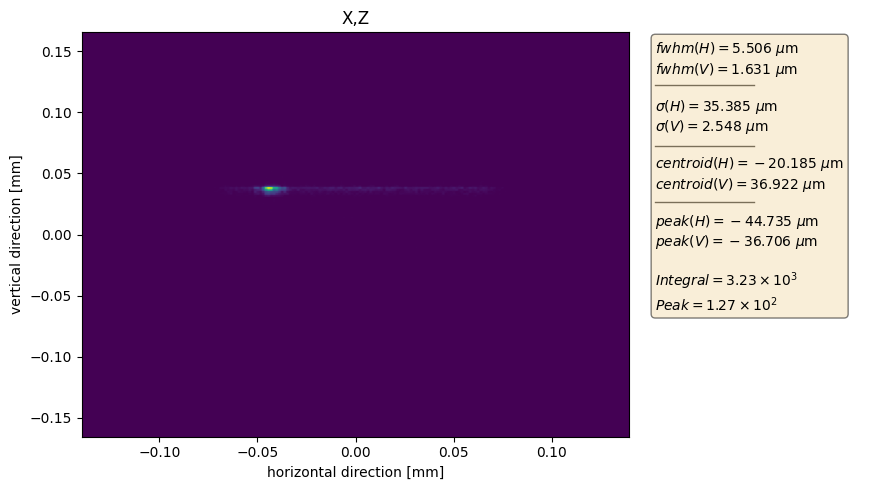

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.
[1.3415950075024405, -4.391330756685709]


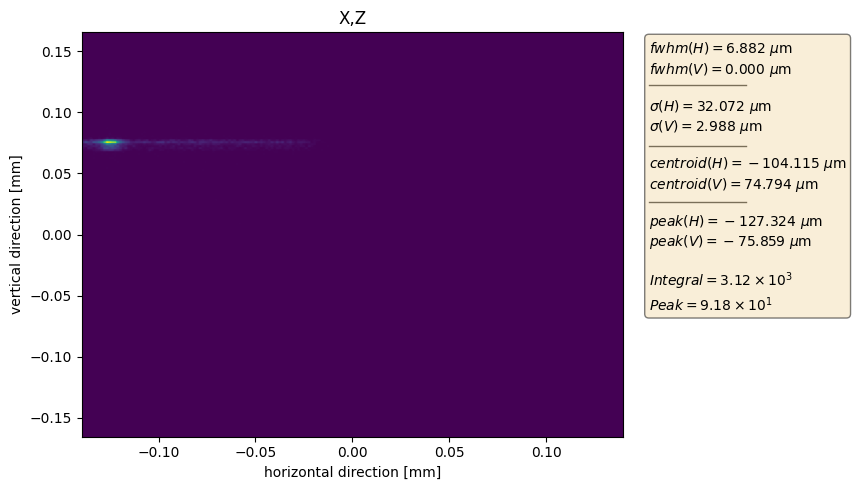

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.
[1.3415890920860931, -4.051377760930098]


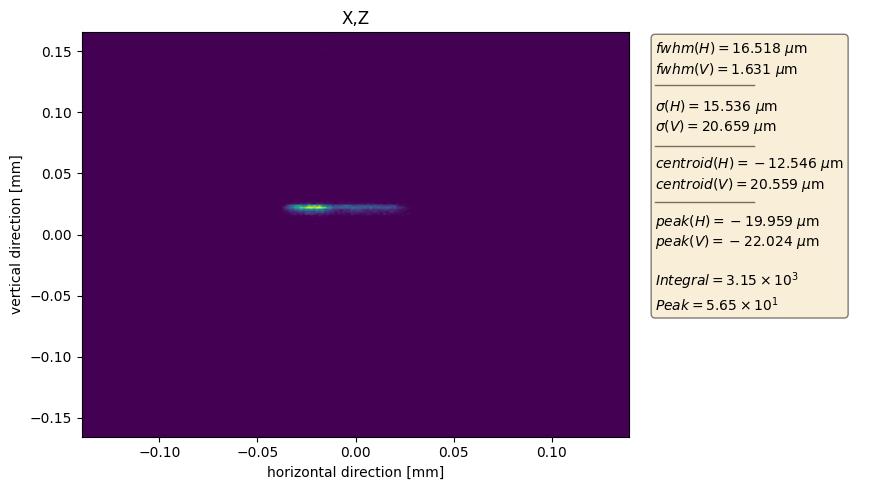

In [46]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)

    opt_common.plot_distribution(photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)
    # plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    # print(vals)
    # plt.figure(figsize=[5, 5])
    # plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    # plt.axis("off")
    # plt.show()

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.
[1.3415968966454093, -4.939639812741813]


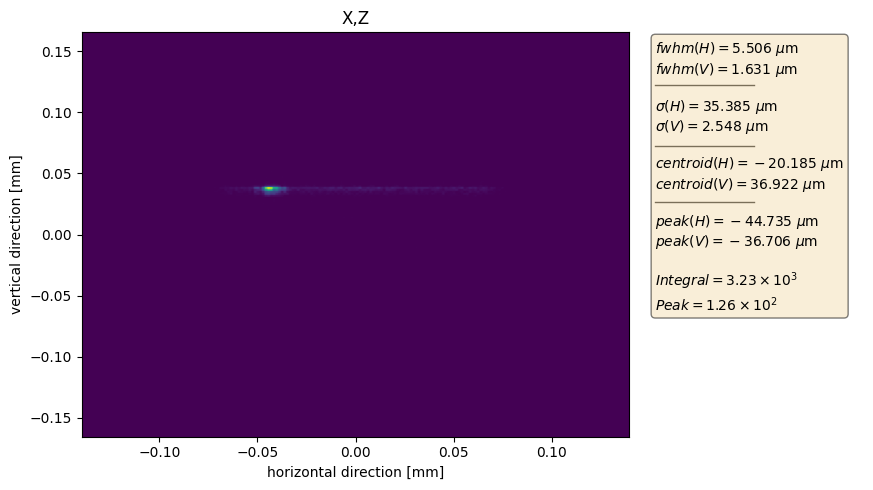

In [47]:
params, values = opt_trial.select_best_trial_params(
    opt_trial.study.best_trials, algorithm=opt_common.SelectionAlgorithm.NASH_EQUILIBRIUM
)
current_params = []
for mot in params:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(values)

opt_common.plot_distribution(photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)

#### KL Divergence without removing noise, with larger fwhm

In [83]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement="absolute")

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/aps/common/plot/image.py:64: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/aps/common/plot/image.py:73: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)


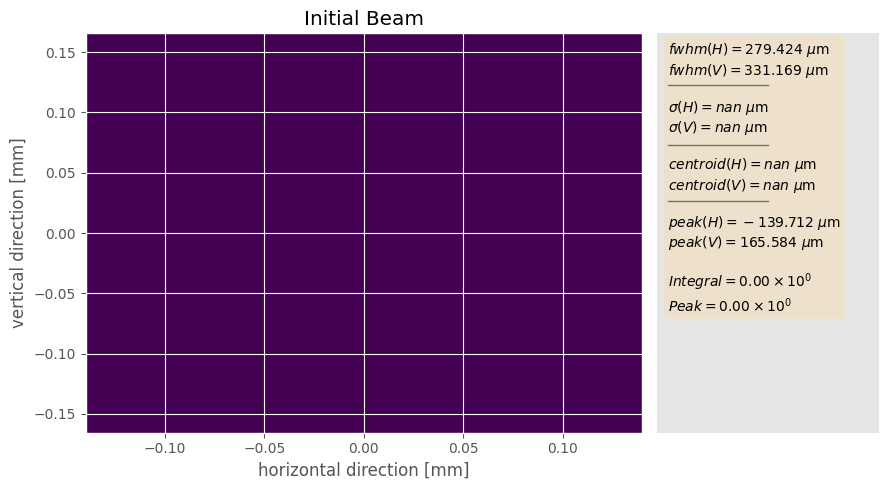

In [84]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam_pert, title="Initial Beam", ppm=ppm)

In [85]:
opt_params = OptimizationParameters()

In [86]:
attribs_init = print_beam_attributes(cp, opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system kl_divergence: 1.342e+00
Perturbed beam system negative_log_peak_intensity: -3.828e+00


In [87]:
# Now the optimization
opt_trial = OptunaOptimizer(
    calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    reference_parameters_h_v={"fwhm": (10e-3, 10e-3)},
)

In [88]:
moo_thresholds = None
if opt_params.params["multi_objective_optimization"]:
    moo_thresholds = opt_params.params["moo_thresholds"]
    for ltype in opt_params.params["loss_parameters"]:
        if ltype not in moo_thresholds:
            moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [89]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds,
)

[I 2023-05-22 16:04:45,433] A new study created in memory with name: no-name-aff62d70-3410-477f-a6ac-20a1b236a37c


In [90]:
opt_trial.trials(50)  # , trial_motor_types=['hb_pitch', 'hb_trans', 'vb_pitch', 'vb_trans'])

/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(
[I 2023-05-22 16:06:28,591] Trial 0 finished with values: [1.3395890101205243, -3.8293014618316303] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': 0.0, 'vb_bender': 0.0, 'vb_pitch': 0.0, 'vb_trans': 0.0}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:06:35,894] Trial 1 finished with values: [1.339548805245137, -2.2803609789379236] and parameters: {'hb_1': 6.0, 'hb_2': -17.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': 0.016100000000000003, 'vb_bender': -8.0, 'vb_pitch': -0.00142, 'vb_trans': -0.0287}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:06:42,785] Trial 2 finished with values: [1.3395518381697582, -2.2667696475553893] and parameters: {'hb_1': -4.0, 'hb_2': -13.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': 0.029400000000000003, 'vb_bender': -11.0, 'vb_pitch': -0.00168, 'vb_trans': 0.010100000000000005}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:06:49,797] Trial 3 finished with values: [1.3395642151946912, -2.0231185565870624] and parameters: {'hb_1': 6.0, 'hb_2': -12.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.022899999999999997, 'vb_bender': -17.0, 'vb_pitch': 0.0016000000000000003, 'vb_trans': 0.017600000000000005}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:06:57,380] Trial 4 finished with values: [1.3395890074675172, -2.16632563094331] and parameters: {'hb_1': 17.0, 'hb_2': 16.0, 'hb_pitch': 0.0019, 'hb_trans': 0.0046, 'vb_bender': 13.0, 'vb_pitch': -0.00031999999999999997, 'vb_trans': -0.028399999999999998}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:07:04,773] Trial 5 finished with values: [1.3395507027206475, -3.2619705174928404] and parameters: {'hb_1': -2.0, 'hb_2': -20.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.011800000000000005, 'vb_bender': 3.0, 'vb_pitch': -0.00092, 'vb_trans': 0.0299}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:07:12,814] Trial 6 finished with values: [1.3395809002997396, -3.624571056926039] and parameters: {'hb_1': -18.0, 'hb_2': 6.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': -0.005699999999999997, 'vb_bender': 9.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': -0.005999999999999998}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:07:19,590] Trial 7 finished with values: [1.339561810744743, -2.6722593148202343] and parameters: {'hb_1': -9.0, 'hb_2': 23.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.018800000000000004, 'vb_bender': -19.0, 'vb_pitch': 0.0017600000000000003, 'vb_trans': 0.027000000000000003}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:07:26,859] Trial 8 finished with values: [1.3395760569591995, -3.0249498093030094] and parameters: {'hb_1': 16.0, 'hb_2': -1.0, 'hb_pitch': 0.0018, 'hb_trans': -0.0049999999999999975, 'vb_bender': -7.0, 'vb_pitch': -0.00194, 'vb_trans': -0.0278}. 


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:07:34,842] Trial 9 finished with values: [1.339564585668354, -2.748833353123273] and parameters: {'hb_1': -23.0, 'hb_2': -19.0, 'hb_pitch': -0.0019, 'hb_trans': -0.0165, 'vb_bender': 2.0, 'vb_pitch': -0.0013, 'vb_trans': -0.019299999999999998}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and s

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:07:44,897] Trial 10 finished with values: [1.3395439330321213, -2.759073846552167] and parameters: {'hb_1': -5.0, 'hb_2': -16.0, 'hb_pitch': 0.0004000000000000002, 'hb_trans': 0.017800000000000003, 'vb_bender': 8.0, 'vb_pitch': -0.00013999999999999993, 'vb_trans': 0.016800000000000002}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is speci

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:07:54,707] Trial 11 finished with values: [1.3395856660642036, -3.3367486952570964] and parameters: {'hb_1': 1.0, 'hb_2': -14.0, 'hb_pitch': 0.0004000000000000002, 'hb_trans': 0.007800000000000001, 'vb_bender': 1.0, 'vb_pitch': -0.00013999999999999993, 'vb_trans': -0.003199999999999998}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is spec

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:08:05,240] Trial 12 finished with values: [1.3395481639319033, -3.0498042008382313] and parameters: {'hb_1': -18.0, 'hb_2': -11.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': 0.0097, 'vb_bender': 4.0, 'vb_pitch': -0.0012000000000000001, 'vb_trans': 0.029200000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:08:25,379] Trial 14 finished with values: [1.3395576327686218, -3.9213864341952904] and parameters: {'hb_1': -14.0, 'hb_2': -16.0, 'hb_pitch': 0.0017000000000000001, 'hb_trans': 0.013700000000000004, 'vb_bender': -2.0, 'vb_pitch': -0.00084, 'vb_trans': 0.0245}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.02990000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:08:36,486] Trial 15 finished with values: [1.3395675671357248, -2.488136419495011] and parameters: {'hb_1': -16.0, 'hb_2': -23.0, 'hb_pitch': 0.0013, 'hb_trans': 0.0221, 'vb_bender': 10.0, 'vb_pitch': -5.999999999999994e-05, 'vb_trans': 0.025100000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.0299000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:08:44,828] Trial 16 finished with values: [1.3395465705178389, -0.8551966959953073] and parameters: {'hb_1': -22.0, 'hb_2': 19.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.0233, 'vb_bender': 11.0, 'vb_pitch': -0.00152, 'vb_trans': 0.023400000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:08:55,556] Trial 17 finished with values: [1.3395639282743972, -3.287261826983174] and parameters: {'hb_1': -16.0, 'hb_2': -10.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.008300000000000002, 'vb_bender': -6.0, 'vb_pitch': -0.00011999999999999988, 'vb_trans': 0.024400000000000005}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is spe

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:09:06,623] Trial 18 finished with values: [1.3395603669767102, -1.5441246871918215] and parameters: {'hb_1': -6.0, 'hb_2': -10.0, 'hb_pitch': 0.0011000000000000003, 'hb_trans': 0.014000000000000005, 'vb_bender': -6.0, 'vb_pitch': -0.00156, 'vb_trans': 0.029300000000000007}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:09:16,778] Trial 19 finished with values: [1.3395307804460395, -3.238649519892368] and parameters: {'hb_1': -15.0, 'hb_2': -21.0, 'hb_pitch': 0.0002999999999999999, 'hb_trans': 0.020500000000000004, 'vb_bender': -7.0, 'vb_pitch': -0.0005, 'vb_trans': 0.021900000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:09:26,831] Trial 20 finished with values: [1.3395516726386978, -2.6055039917282454] and parameters: {'hb_1': -2.0, 'hb_2': -11.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.015300000000000001, 'vb_bender': -9.0, 'vb_pitch': -0.0004599999999999999, 'vb_trans': 0.017400000000000006}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is spec

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:09:35,355] Trial 21 finished with values: [1.3395532441622553, -1.8003571107885807] and parameters: {'hb_1': -21.0, 'hb_2': -7.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': 0.021900000000000003, 'vb_bender': -16.0, 'vb_pitch': 2.0000000000000052e-05, 'vb_trans': 0.023100000000000002}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is s

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:09:43,862] Trial 22 finished with values: [1.339550450285911, -2.7021256945809755] and parameters: {'hb_1': -9.0, 'hb_2': -21.0, 'hb_pitch': 0.0007000000000000001, 'hb_trans': 0.011000000000000003, 'vb_bender': -9.0, 'vb_pitch': -0.0002999999999999999, 'vb_trans': 0.015300000000000001}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is speci

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:09:54,026] Trial 23 finished with values: [1.3395627498495721, -2.974460150304768] and parameters: {'hb_1': 3.0, 'hb_2': -16.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': 0.020800000000000006, 'vb_bender': 2.0, 'vb_pitch': -0.0005199999999999998, 'vb_trans': 0.024}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:10:04,392] Trial 24 finished with values: [1.3395812019155136, -4.071235824024622] and parameters: {'hb_1': -11.0, 'hb_2': -18.0, 'hb_pitch': 0.0017000000000000001, 'hb_trans': 0.021700000000000004, 'vb_bender': 4.0, 'vb_pitch': -0.0009599999999999999, 'vb_trans': 0.020500000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is speci

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:10:15,848] Trial 25 finished with values: [1.3395476132619681, -2.8094123420729153] and parameters: {'hb_1': -21.0, 'hb_2': -24.0, 'hb_pitch': 0.0015, 'hb_trans': 0.004900000000000002, 'vb_bender': 4.0, 'vb_pitch': -0.00108, 'vb_trans': 0.013700000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.0299000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:10:26,706] Trial 26 finished with values: [1.339568608504591, -3.422505576234284] and parameters: {'hb_1': -17.0, 'hb_2': -16.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': 0.017100000000000004, 'vb_bender': -1.0, 'vb_pitch': -0.00104, 'vb_trans': 0.014100000000000001}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:10:37,696] Trial 27 finished with values: [1.3395906126823616, -4.717717179424696] and parameters: {'hb_1': -11.0, 'hb_2': -8.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': 0.005600000000000001, 'vb_bender': -2.0, 'vb_pitch': 0.00022000000000000014, 'vb_trans': 0.005500000000000005}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is speci

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:10:50,221] Trial 28 finished with values: [1.3395315159961734, -1.5183228768308672] and parameters: {'hb_1': -14.0, 'hb_2': -14.0, 'hb_pitch': 0.0007000000000000001, 'hb_trans': 0.018400000000000007, 'vb_bender': -1.0, 'vb_pitch': -0.0002599999999999998, 'vb_trans': 0.015600000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is spe

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:11:01,288] Trial 29 finished with values: [1.339548684454799, -1.8369606036706303] and parameters: {'hb_1': -25.0, 'hb_2': -21.0, 'hb_pitch': 0.0007000000000000001, 'hb_trans': 0.0291, 'vb_bender': -16.0, 'vb_pitch': -0.00082, 'vb_trans': 0.021500000000000005}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.02990000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:11:13,237] Trial 30 finished with values: [1.3395653767023863, -3.0956436710831707] and parameters: {'hb_1': -10.0, 'hb_2': -22.0, 'hb_pitch': 0.0, 'hb_trans': 0.027200000000000002, 'vb_bender': 12.0, 'vb_pitch': -0.001, 'vb_trans': 0.015900000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.02990000000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:11:25,371] Trial 31 finished with values: [1.3395757438920317, -2.5094329786245377] and parameters: {'hb_1': -6.0, 'hb_2': -2.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': 0.013600000000000001, 'vb_bender': 9.0, 'vb_pitch': 0.00031999999999999997, 'vb_trans': 0.0177}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03,

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:11:36,588] Trial 32 finished with values: [1.3395829123048897, -4.228812487459858] and parameters: {'hb_1': -12.0, 'hb_2': 4.0, 'hb_pitch': 0.0013, 'hb_trans': -0.0002999999999999982, 'vb_bender': -4.0, 'vb_pitch': 4.0000000000000105e-05, 'vb_trans': 0.012700000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:11:49,719] Trial 33 finished with values: [1.3395767673056593, -2.1426302406761084] and parameters: {'hb_1': -19.0, 'hb_2': -19.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': 0.014700000000000005, 'vb_bender': -17.0, 'vb_pitch': -0.00098, 'vb_trans': 0.0172}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.0299000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:12:01,893] Trial 34 finished with values: [1.3395881072690559, -4.392577698006566] and parameters: {'hb_1': -21.0, 'hb_2': 4.0, 'hb_pitch': 0.0017000000000000001, 'hb_trans': -0.005299999999999999, 'vb_bender': -1.0, 'vb_pitch': -3.999999999999967e-05, 'vb_trans': 0.018800000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is speci

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:12:13,721] Trial 35 finished with values: [1.3395717986501916, -3.80081663892099] and parameters: {'hb_1': -3.0, 'hb_2': 2.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': -0.005799999999999996, 'vb_bender': -5.0, 'vb_pitch': 0.00031999999999999997, 'vb_trans': 0.021700000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specif

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:12:25,129] Trial 36 finished with values: [1.3395720997669458, -4.249656857848784] and parameters: {'hb_1': -9.0, 'hb_2': -5.0, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.0022999999999999965, 'vb_bender': 0.0, 'vb_pitch': 0.00018000000000000004, 'vb_trans': 0.0199}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:12:37,276] Trial 37 finished with values: [1.3396146027359987, -4.287762404423473] and parameters: {'hb_1': -16.0, 'hb_2': 0.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.008599999999999997, 'vb_bender': -2.0, 'vb_pitch': 0.00015999999999999999, 'vb_trans': 0.0039000000000000007}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is sp

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:12:49,787] Trial 38 finished with values: [1.33954340339975, -3.672882081300439] and parameters: {'hb_1': -21.0, 'hb_2': 14.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.007899999999999997, 'vb_bender': 0.0, 'vb_pitch': -3.999999999999967e-05, 'vb_trans': 0.028200000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is speci

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:13:01,571] Trial 39 finished with values: [1.3395846140092895, -4.140209479184962] and parameters: {'hb_1': -14.0, 'hb_2': 1.0, 'hb_pitch': -0.0015, 'hb_trans': -0.009799999999999996, 'vb_bender': -6.0, 'vb_pitch': 0.00034, 'vb_trans': 0.028200000000000003}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.02990000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:13:12,361] Trial 40 finished with values: [1.3395437205979897, -3.5318662203241016] and parameters: {'hb_1': -18.0, 'hb_2': -19.0, 'hb_pitch': 0.0015, 'hb_trans': -0.0168, 'vb_bender': -1.0, 'vb_pitch': 0.00018000000000000004, 'vb_trans': 0.029700000000000004}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.02990000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:13:23,711] Trial 41 finished with values: [1.3395898130401227, -3.699952592765388] and parameters: {'hb_1': -17.0, 'hb_2': -5.0, 'hb_pitch': 0.0005, 'hb_trans': -0.0036999999999999984, 'vb_bender': -2.0, 'vb_pitch': 0.00015999999999999999, 'vb_trans': 0.029800000000000007}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:13:35,278] Trial 42 finished with values: [1.3395674868102054, -3.584620664660414] and parameters: {'hb_1': -4.0, 'hb_2': -23.0, 'hb_pitch': 0.0013, 'hb_trans': -0.002799999999999997, 'vb_bender': -3.0, 'vb_pitch': 0.0002800000000000003, 'vb_trans': -0.007499999999999996}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:13:47,987] Trial 43 finished with values: [1.339591356686324, -3.0031669096292317] and parameters: {'hb_1': -23.0, 'hb_2': -10.0, 'hb_pitch': 0.0, 'hb_trans': 0.015400000000000004, 'vb_bender': 0.0, 'vb_pitch': -0.0008599999999999999, 'vb_trans': 0.029300000000000007}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:14:00,241] Trial 44 finished with values: [1.3395414679509128, -4.05288686236775] and parameters: {'hb_1': -13.0, 'hb_2': -19.0, 'hb_pitch': 0.0009000000000000002, 'hb_trans': -0.0019999999999999983, 'vb_bender': 1.0, 'vb_pitch': -9.999999999999983e-05, 'vb_trans': 0.014600000000000002}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is spec

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:14:14,442] Trial 45 finished with values: [1.3395882398088643, -4.373781639718862] and parameters: {'hb_1': -13.0, 'hb_2': -16.0, 'hb_pitch': 0.0009000000000000002, 'hb_trans': 0.00030000000000000165, 'vb_bender': -1.0, 'vb_pitch': 0.00015999999999999999, 'vb_trans': 0.0126}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:14:26,350] Trial 46 finished with values: [1.339551821570129, -3.5497870345944196] and parameters: {'hb_1': -7.0, 'hb_2': -24.0, 'hb_pitch': 0.0006000000000000003, 'hb_trans': 0.0223, 'vb_bender': -4.0, 'vb_pitch': -0.00066, 'vb_trans': 0.025500000000000002}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.0299000000

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:14:39,871] Trial 47 finished with values: [1.3395530768931023, -4.022796670923751] and parameters: {'hb_1': -12.0, 'hb_2': -20.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': -0.007099999999999999, 'vb_bender': 1.0, 'vb_pitch': -0.00017999999999999982, 'vb_trans': 0.0013000000000000025}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is sp

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:14:51,736] Trial 48 finished with values: [1.3395604434279782, -3.1541192018271262] and parameters: {'hb_1': -18.0, 'hb_2': -15.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': -0.011799999999999998, 'vb_bender': 4.0, 'vb_pitch': 0.00013999999999999993, 'vb_trans': -0.001299999999999999}. 
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is s

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-22 16:15:07,074] Trial 49 finished with values: [1.3395762581217363, -3.2485329259017104] and parameters: {'hb_1': 1.0, 'hb_2': -25.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.0036999999999999984, 'vb_bender': -4.0, 'vb_pitch': -9.999999999999983e-05, 'vb_trans': 0.0119}. 


/tmp/ipykernel_758275/2987871832.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(


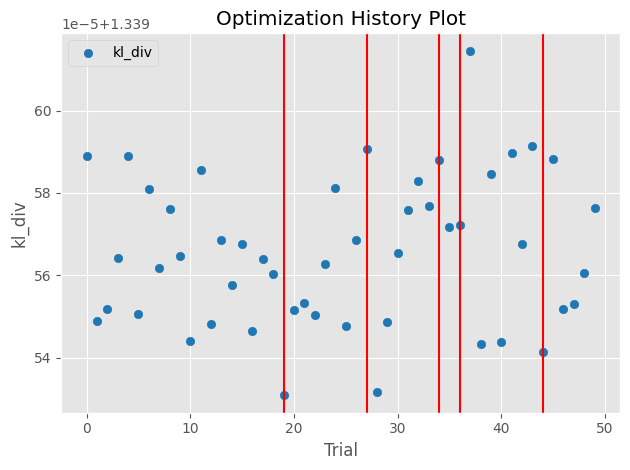

In [91]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(
    opt_trial.study, target=lambda t: t.values[0], target_name="kl_div"
)
for t in opt_trial.study.best_trials:
    plt.axvline(t.number, color="red")
# plt.axvline(nash_trial.number, color="orange")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/tmp/ipykernel_758275/740841843.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(


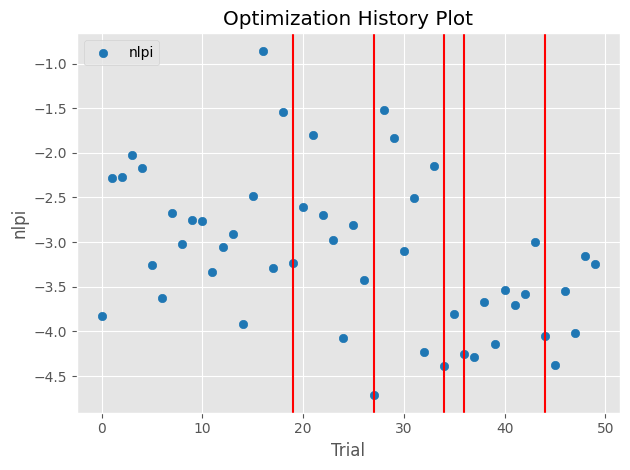

In [92]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(
    opt_trial.study, target=lambda t: t.values[1], target_name="nlpi"
)
for t in opt_trial.study.best_trials:
    plt.axvline(t.number, color="red")
# plt.axvline(nash_trial.number, color="orange")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [93]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs["ws"])

nan 207251.86732941077
nan 207573.94831842338
nan 207576.5801028653
nan 207120.25781019492
nan 207364.53470298945


/tmp/ipykernel_758275/261318559.py:4: RuntimeWarning: invalid value encountered in log
  print(np.log(vals).sum(), t.user_attrs["ws"])


write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.
[1.3395307804460395, -3.238649519892368]


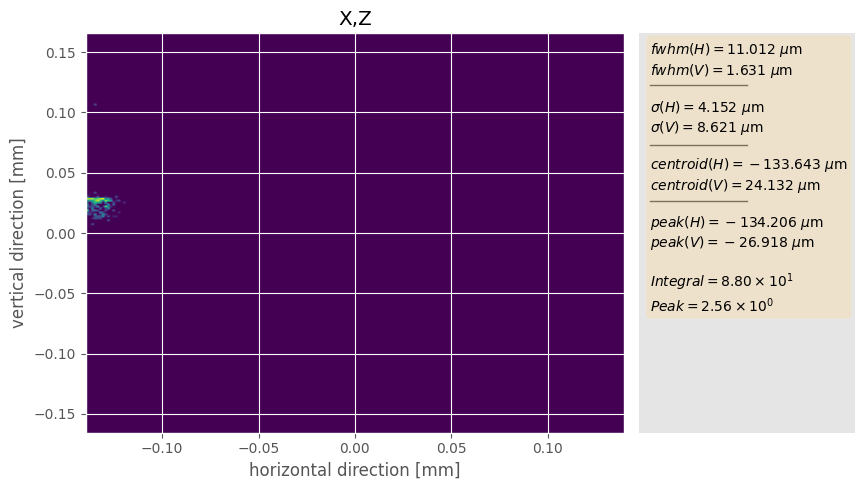

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.
[1.3395906126823616, -4.717717179424696]


/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/aps/common/plot/image.py:64: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)
/home/beams/SKANDEL/miniforge3/envs/oasys/lib/python3.8/site-packages/aps/common/plot/image.py:73: RuntimeWarning: invalid value encountered in true_divide
  frequency = histogram/numpy.sum(histogram)


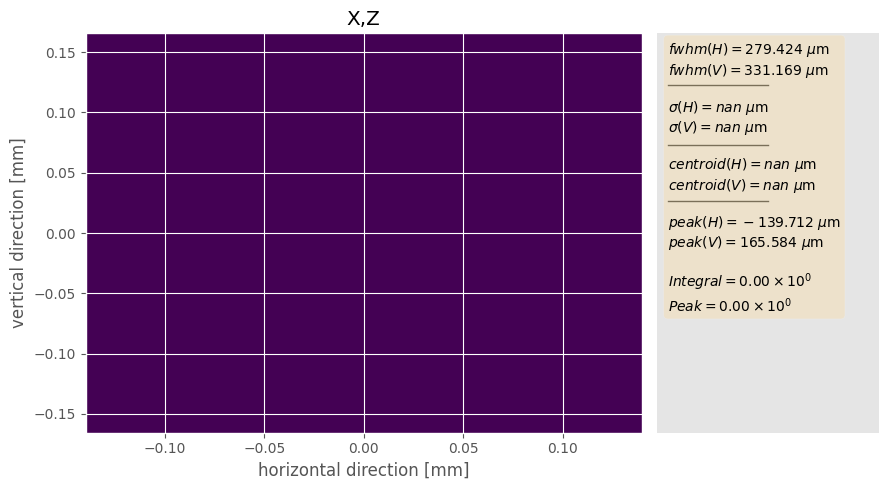

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.
[1.3395881072690559, -4.392577698006566]


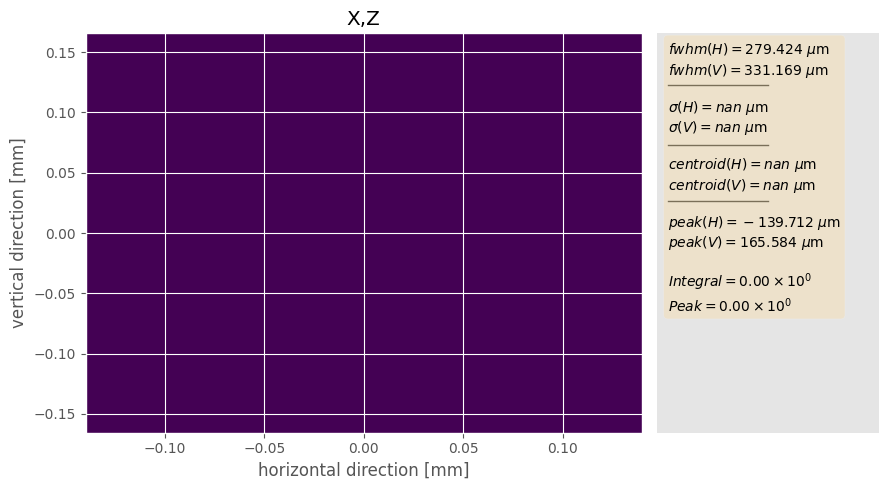

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.
[1.3395720997669458, -4.249656857848784]


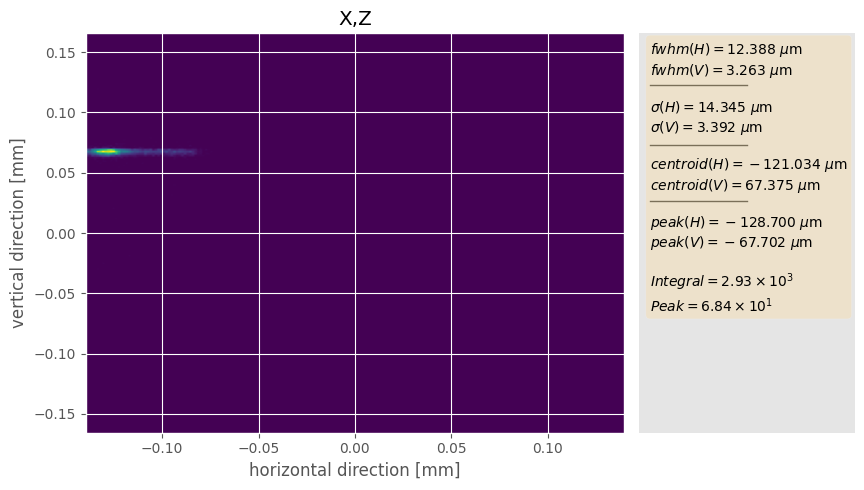

write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /home/beams0/SKANDEL/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_87899/Downstream_HKB_bender_profile.dat written to disk.
[1.3395414679509128, -4.05288686236775]


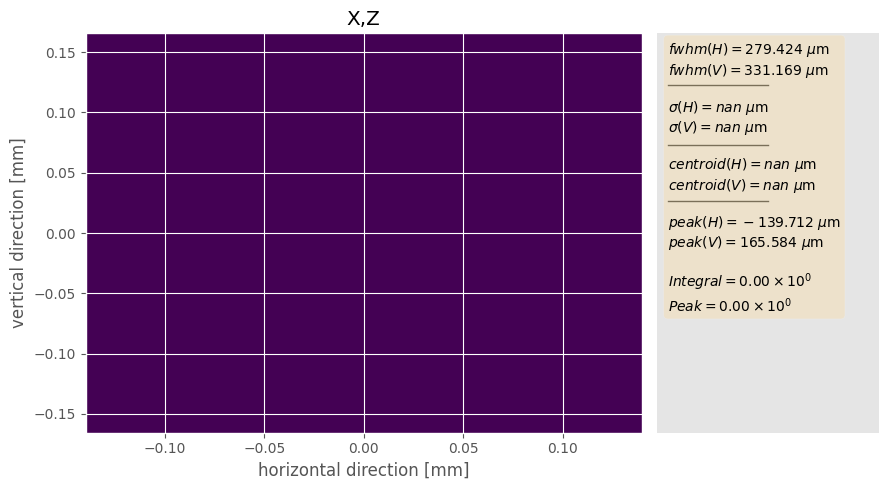

In [94]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)

    opt_common.plot_distribution(photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)
    # plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    # print(vals)
    # plt.figure(figsize=[5, 5])
    # plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    # plt.axis("off")
    # plt.show()

[1.3395414679509128, -4.05288686236775]


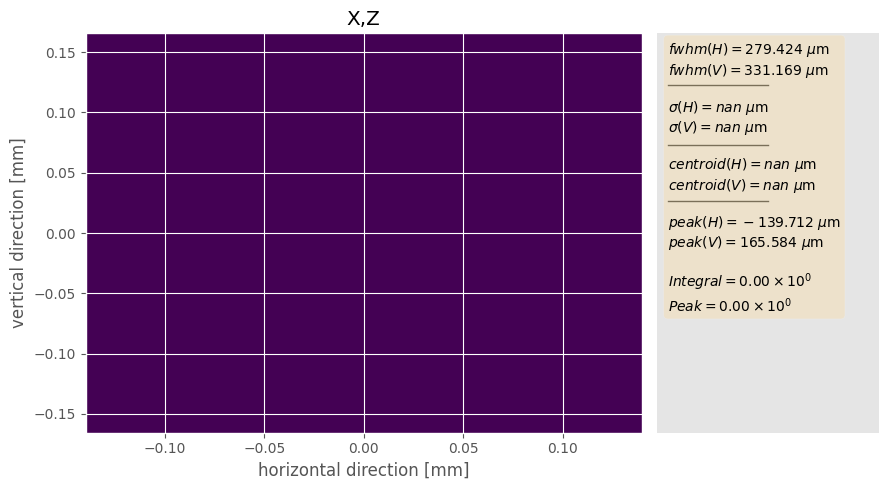

In [95]:
params, values = opt_trial.select_best_trial_params(
    opt_trial.study.best_trials, algorithm=opt_common.SelectionAlgorithm.NASH_EQUILIBRIUM
)
current_params = []
for mot in params:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(values)

opt_common.plot_distribution(photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)

/tmp/ipykernel_758275/2059645299.py:3: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(


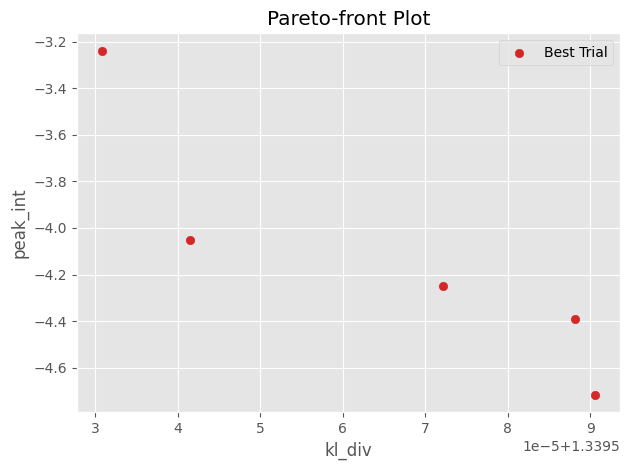

In [98]:
# Generating the pareto front for the multiobjective optimization

optuna.visualization.matplotlib.plot_pareto_front(
    opt_trial.study, target_names=["kl_div", "peak_int"], include_dominated_trials=False
)
# plt.scatter(*nash_trial.values, color='orange', label='Nash')
plt.legend(loc="best")
plt.tight_layout()

# plt.savefig(...) to save the image
plt.show()

#### KL Divergence after removing noise

In [36]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement="absolute")

In [37]:
cp = dt.replace(cp, calculate_over_noise=True)

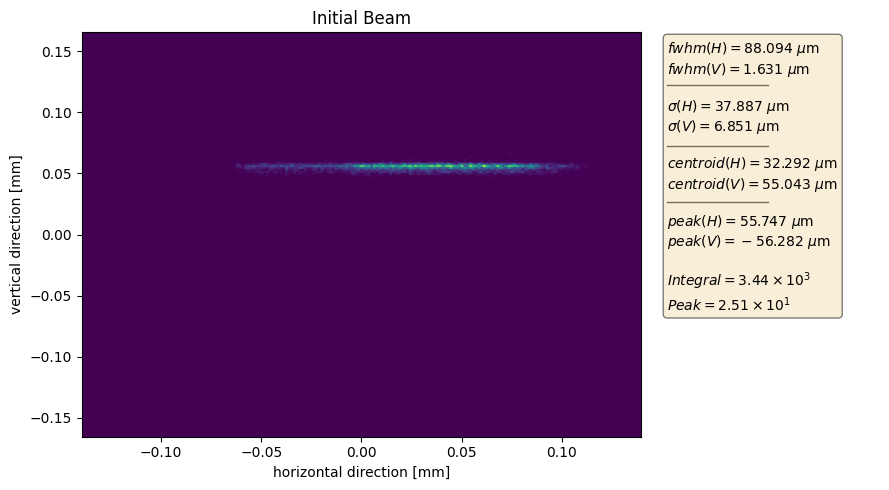

In [38]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam_pert, title="Initial Beam", ppm=ppm)

In [39]:
attribs_init = print_beam_attributes(cp, opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system kl_divergence: 1.386e+00
Perturbed beam system negative_log_peak_intensity: -3.125e+00


In [40]:
opt_params = OptimizationParameters()

In [41]:
# Now the optimization
opt_trial = OptunaOptimizer(
    calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    reference_parameters_h_v={"fwhm": (5e-3, 5e-3)},
)

In [42]:
moo_thresholds = None
if opt_params.params["multi_objective_optimization"]:
    moo_thresholds = opt_params.params["moo_thresholds"]
    for ltype in opt_params.params["loss_parameters"]:
        if ltype not in moo_thresholds:
            moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [43]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds,
)

[I 2023-05-23 16:37:13,715] A new study created in memory with name: no-name-7a01ee3c-14da-4eb0-b41b-b1ce9719037d


In [44]:
opt_trial.trials(50)  # , trial_motor_types=['hb_pitch', 'hb_trans', 'vb_pitch', 'vb_trans'])

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(
[I 2023-05-23 16:37:22,313] Trial 0 finished with values: [1.3861906365772103, -3.1204544824910627] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': 0.0, 'vb_bender': 0.0, 'vb_pitch': 0.0, 'vb_trans': 0.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:37:31,019] Trial 1 finished with values: [1.3858092141922014, -1.258951927951235] and parameters: {'hb_1': 6.0, 'hb_2': -17.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': 0.016100000000000003, 'vb_bender': -8.0, 'vb_pitch': -0.00142, 'vb_trans': -0.0287}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:37:39,502] Trial 2 finished with values: [1.3324041861051936, -2.831987148123365] and parameters: {'hb_1': -4.0, 'hb_2': -13.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': 0.029400000000000003, 'vb_bender': -11.0, 'vb_pitch': -0.00168, 'vb_trans': 0.010100000000000005}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:37:48,103] Trial 3 finished with values: [1.386083722539913, -2.648272765848609] and parameters: {'hb_1': 6.0, 'hb_2': -12.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.022899999999999997, 'vb_bender': -17.0, 'vb_pitch': 0.0016000000000000003, 'vb_trans': 0.017600000000000005}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:37:56,888] Trial 4 finished with values: [1.386046610823471, -2.1746298098718504] and parameters: {'hb_1': 17.0, 'hb_2': 16.0, 'hb_pitch': 0.0019, 'hb_trans': 0.0046, 'vb_bender': 13.0, 'vb_pitch': -0.00031999999999999997, 'vb_trans': -0.028399999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:38:05,302] Trial 5 finished with values: [1.3861922461434537, -3.722191120535468] and parameters: {'hb_1': -2.0, 'hb_2': -20.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.011800000000000005, 'vb_bender': 3.0, 'vb_pitch': -0.00092, 'vb_trans': 0.0299}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:38:14,138] Trial 6 finished with values: [1.2365710266155023, -2.0886214426912124] and parameters: {'hb_1': -18.0, 'hb_2': 6.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': -0.005699999999999997, 'vb_bender': 9.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': -0.005999999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:38:22,560] Trial 7 finished with values: [1.385923066774937, -1.402230741106182] and parameters: {'hb_1': -9.0, 'hb_2': 23.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.018800000000000004, 'vb_bender': -19.0, 'vb_pitch': 0.0017600000000000003, 'vb_trans': 0.027000000000000003}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:38:31,342] Trial 8 finished with values: [1.3861539192319456, -2.6279062182002466] and parameters: {'hb_1': 16.0, 'hb_2': -1.0, 'hb_pitch': 0.0018, 'hb_trans': -0.0049999999999999975, 'vb_bender': -7.0, 'vb_pitch': -0.00194, 'vb_trans': -0.0278}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:38:40,154] Trial 9 finished with values: [1.386125584549296, -3.5334194280208497] and parameters: {'hb_1': -23.0, 'hb_2': -19.0, 'hb_pitch': -0.0019, 'hb_trans': -0.0165, 'vb_bender': 2.0, 'vb_pitch': -0.0013, 'vb_trans': -0.019299999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:38:56,074] Trial 10 finished with values: [1.3861491971849438, -2.332560528583926] and parameters: {'hb_1': 22.0, 'hb_2': -17.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.026900000000000007, 'vb_bender': 19.0, 'vb_pitch': -0.00106, 'vb_trans': 0.0233}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: Us

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:39:13,632] Trial 11 finished with values: [1.3858801793725541, -2.0034880299999704] and parameters: {'hb_1': -25.0, 'hb_2': -9.0, 'hb_pitch': 0.0009000000000000002, 'hb_trans': -0.024399999999999998, 'vb_bender': -5.0, 'vb_pitch': -0.00023999999999999998, 'vb_trans': 0.005600000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:39:28,183] Trial 12 finished with values: [1.326506173147482, -1.3416720947583864] and parameters: {'hb_1': -5.0, 'hb_2': 5.0, 'hb_pitch': 0.0005, 'hb_trans': -0.014799999999999999, 'vb_bender': -20.0, 'vb_pitch': -0.0003399999999999998, 'vb_trans': 0.021500000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:39:45,242] Trial 13 finished with values: [1.3860509274972752, -1.980628653873103] and parameters: {'hb_1': 3.0, 'hb_2': -25.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': -0.0032999999999999974, 'vb_bender': -14.0, 'vb_pitch': 0.00168, 'vb_trans': 0.005500000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:40:02,093] Trial 14 finished with values: [1.3859958914836876, -1.9681470560881493] and parameters: {'hb_1': 4.0, 'hb_2': 7.0, 'hb_pitch': -0.0016, 'hb_trans': 0.025800000000000003, 'vb_bender': 16.0, 'vb_pitch': -0.0009399999999999999, 'vb_trans': 0.004300000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distribution

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:40:18,216] Trial 15 finished with values: [1.3860461224336371, -2.0000871951124672] and parameters: {'hb_1': 0.0, 'hb_2': -6.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': 0.028900000000000002, 'vb_bender': 14.0, 'vb_pitch': 0.0014600000000000004, 'vb_trans': 0.008400000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:40:34,960] Trial 16 finished with values: [1.3593991488995534, -1.9199433597205786] and parameters: {'hb_1': -22.0, 'hb_2': -1.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': -0.012799999999999999, 'vb_bender': -13.0, 'vb_pitch': 0.00068, 'vb_trans': -0.009799999999999996}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distri

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:40:51,664] Trial 17 finished with values: [1.334425320217458, -2.7034013124183036] and parameters: {'hb_1': 22.0, 'hb_2': 10.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': 0.0267, 'vb_bender': 15.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': 0.009100000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distribut

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:41:08,671] Trial 18 finished with values: [1.3860739450401414, -2.8641472127160417] and parameters: {'hb_1': -7.0, 'hb_2': -17.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': 0.026500000000000003, 'vb_bender': -10.0, 'vb_pitch': -0.0012799999999999999, 'vb_trans': 0.015300000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:41:26,356] Trial 19 finished with values: [1.329477930592014, -2.018999486067437] and parameters: {'hb_1': -12.0, 'hb_2': 20.0, 'hb_pitch': -0.00039999999999999996, 'hb_trans': 0.0182, 'vb_bender': 8.0, 'vb_pitch': 0.0017400000000000002, 'vb_trans': -0.0165}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: Us

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:41:43,102] Trial 20 finished with values: [1.3710763626518343, -1.9492537970914852] and parameters: {'hb_1': -22.0, 'hb_2': 3.0, 'hb_pitch': -0.0012000000000000001, 'hb_trans': 0.0006000000000000033, 'vb_bender': -9.0, 'vb_pitch': -0.0004599999999999999, 'vb_trans': 0.0030000000000000027}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:41:59,862] Trial 21 finished with values: [1.38600108130256, -1.7143568204892026] and parameters: {'hb_1': -1.0, 'hb_2': 6.0, 'hb_pitch': 0.0002999999999999999, 'hb_trans': -0.028999999999999998, 'vb_bender': -16.0, 'vb_pitch': -0.00098, 'vb_trans': 0.021300000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:42:17,044] Trial 22 finished with values: [1.385976584060215, -1.8488532983868728] and parameters: {'hb_1': 25.0, 'hb_2': -17.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.023399999999999997, 'vb_bender': -9.0, 'vb_pitch': -0.00027999999999999987, 'vb_trans': 0.020700000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:42:34,543] Trial 23 finished with values: [1.3860847524859377, -2.8067383278904194] and parameters: {'hb_1': -6.0, 'hb_2': -18.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.026600000000000006, 'vb_bender': 10.0, 'vb_pitch': -0.002, 'vb_trans': -0.016599999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:42:50,664] Trial 24 finished with values: [1.385781782913135, -0.8545181181010388] and parameters: {'hb_1': -11.0, 'hb_2': -2.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.011199999999999998, 'vb_bender': -11.0, 'vb_pitch': -0.00152, 'vb_trans': 0.0187}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: 

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:43:07,755] Trial 25 finished with values: [1.3859424831816425, -1.982152721066237] and parameters: {'hb_1': -13.0, 'hb_2': -7.0, 'hb_pitch': -0.0005, 'hb_trans': 0.0039000000000000007, 'vb_bender': -17.0, 'vb_pitch': -0.00019999999999999987, 'vb_trans': -0.016399999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distri

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:43:24,360] Trial 26 finished with values: [1.385990671337092, -2.3526238652356595] and parameters: {'hb_1': -12.0, 'hb_2': -9.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.016600000000000004, 'vb_bender': -19.0, 'vb_pitch': 0.0018000000000000004, 'vb_trans': -0.0208}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distribut

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:43:41,272] Trial 27 finished with values: [1.386092894056284, -2.2689671946266308] and parameters: {'hb_1': 22.0, 'hb_2': -4.0, 'hb_pitch': 0.0015, 'hb_trans': -0.0286, 'vb_bender': 20.0, 'vb_pitch': 8.000000000000021e-05, 'vb_trans': -0.0278}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The 

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:43:58,032] Trial 28 finished with values: [1.3859169970435632, -1.4341474365405886] and parameters: {'hb_1': -23.0, 'hb_2': 6.0, 'hb_pitch': -0.0015, 'hb_trans': -0.0215, 'vb_bender': 19.0, 'vb_pitch': -0.0003399999999999998, 'vb_trans': 0.015100000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: U

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:44:16,460] Trial 29 finished with values: [1.3861854042413364, -3.1832695027330633] and parameters: {'hb_1': 10.0, 'hb_2': 2.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': -0.009499999999999998, 'vb_bender': 5.0, 'vb_pitch': 0.00068, 'vb_trans': -0.0236}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: Us

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:44:35,159] Trial 30 finished with values: [1.3861139824452777, -2.8982573451751446] and parameters: {'hb_1': -17.0, 'hb_2': 13.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': -0.003199999999999998, 'vb_bender': -2.0, 'vb_pitch': -0.00039999999999999996, 'vb_trans': -0.009599999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:44:54,305] Trial 31 finished with values: [1.3580718741982438, -1.5905360318371862] and parameters: {'hb_1': -5.0, 'hb_2': 19.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.009399999999999999, 'vb_bender': 20.0, 'vb_pitch': -0.0019, 'vb_trans': 0.020700000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:45:12,002] Trial 32 finished with values: [1.3860676176094073, -3.152231669360265] and parameters: {'hb_1': -17.0, 'hb_2': -18.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.0279, 'vb_bender': -9.0, 'vb_pitch': 0.0009400000000000003, 'vb_trans': -0.0224}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: U

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:45:30,114] Trial 33 finished with values: [1.3859048831271963, -1.9601182836828717] and parameters: {'hb_1': -14.0, 'hb_2': -2.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': 0.009400000000000006, 'vb_bender': -15.0, 'vb_pitch': -0.00013999999999999993, 'vb_trans': -0.010899999999999996}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-package

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:45:47,608] Trial 34 finished with values: [1.386023709013881, -1.865174198051824] and parameters: {'hb_1': -5.0, 'hb_2': 11.0, 'hb_pitch': 0.0019, 'hb_trans': 0.0291, 'vb_bender': -9.0, 'vb_pitch': 0.00010000000000000026, 'vb_trans': 0.029400000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserW

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:46:05,193] Trial 35 finished with values: [1.3859890171767948, -2.0636673111027504] and parameters: {'hb_1': -23.0, 'hb_2': 17.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': 0.026000000000000002, 'vb_bender': -5.0, 'vb_pitch': -0.00027999999999999987, 'vb_trans': 0.0077000000000000055}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-package

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:46:23,583] Trial 36 finished with values: [1.3861763778114666, -3.452202365971742] and parameters: {'hb_1': -4.0, 'hb_2': -21.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': -0.0005999999999999964, 'vb_bender': -1.0, 'vb_pitch': 0.0016600000000000005, 'vb_trans': -0.0247}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distrib

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:46:41,817] Trial 37 finished with values: [1.3860327092398983, -2.7662287175360696] and parameters: {'hb_1': -23.0, 'hb_2': -15.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': 0.023200000000000005, 'vb_bender': 18.0, 'vb_pitch': 0.0005200000000000001, 'vb_trans': 0.0172}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distribut

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:47:00,257] Trial 38 finished with values: [1.3857052227928237, -2.2407716495600187] and parameters: {'hb_1': -9.0, 'hb_2': -8.0, 'hb_pitch': -0.0005, 'hb_trans': -0.013699999999999997, 'vb_bender': 13.0, 'vb_pitch': 0.0015800000000000002, 'vb_trans': -0.014599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distribut

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:47:18,519] Trial 39 finished with values: [1.3859758843379721, -2.262129982866896] and parameters: {'hb_1': -18.0, 'hb_2': -5.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.026800000000000004, 'vb_bender': -16.0, 'vb_pitch': 0.00068, 'vb_trans': -0.0235}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: U

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:47:36,811] Trial 40 finished with values: [1.3858283327167988, -1.10834251205343] and parameters: {'hb_1': -8.0, 'hb_2': -16.0, 'hb_pitch': 0.0015, 'hb_trans': -0.009399999999999999, 'vb_bender': 4.0, 'vb_pitch': -0.00156, 'vb_trans': 0.012100000000000007}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: User

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:47:54,919] Trial 41 finished with values: [1.3860492049233128, -2.3060285423739444] and parameters: {'hb_1': 16.0, 'hb_2': 25.0, 'hb_pitch': -0.0019, 'hb_trans': -0.014299999999999997, 'vb_bender': 11.0, 'vb_pitch': 0.00046000000000000034, 'vb_trans': -0.0163}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: 

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:48:13,733] Trial 42 finished with values: [1.3860922388158166, -2.7195886608194497] and parameters: {'hb_1': 11.0, 'hb_2': 14.0, 'hb_pitch': -0.0014, 'hb_trans': 0.019600000000000006, 'vb_bender': -7.0, 'vb_pitch': 0.0007800000000000003, 'vb_trans': -0.015199999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:48:32,446] Trial 43 finished with values: [1.3548132736925305, -1.6228614097485177] and parameters: {'hb_1': -21.0, 'hb_2': 20.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': 0.025300000000000003, 'vb_bender': -15.0, 'vb_pitch': -0.0009599999999999999, 'vb_trans': -0.000499999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-package

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:48:50,953] Trial 44 finished with values: [1.3860980007055477, -2.4177713564951033] and parameters: {'hb_1': 6.0, 'hb_2': 1.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': -0.0005999999999999964, 'vb_bender': 10.0, 'vb_pitch': -0.00192, 'vb_trans': -0.0254}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: 

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:49:11,573] Trial 45 finished with values: [1.3859436100318259, -1.5370092361719767] and parameters: {'hb_1': -1.0, 'hb_2': 20.0, 'hb_pitch': 0.0018, 'hb_trans': 0.0033000000000000043, 'vb_bender': -19.0, 'vb_pitch': -0.0018, 'vb_trans': 0.027200000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: Us

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:49:30,163] Trial 46 finished with values: [1.3425333789445306, -3.2873649321056595] and parameters: {'hb_1': 8.0, 'hb_2': -15.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': -0.003199999999999998, 'vb_bender': 14.0, 'vb_pitch': 0.0019000000000000002, 'vb_trans': 0.0092}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distribut

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:49:49,759] Trial 47 finished with values: [1.3859790521093522, -1.7760098540207712] and parameters: {'hb_1': -10.0, 'hb_2': 21.0, 'hb_pitch': -0.0009, 'hb_trans': -0.005199999999999996, 'vb_bender': -10.0, 'vb_pitch': 0.00042000000000000023, 'vb_trans': -0.010099999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distri

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:50:09,220] Trial 48 finished with values: [1.3861571753620874, -2.741022159864911] and parameters: {'hb_1': -18.0, 'hb_2': 4.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': -0.0208, 'vb_bender': 3.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': 0.0262}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: Use

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:50:28,014] Trial 49 finished with values: [1.3860574412015343, -2.023101583509045] and parameters: {'hb_1': -11.0, 'hb_2': 15.0, 'hb_pitch': -0.0009, 'hb_trans': -0.021599999999999998, 'vb_bender': 10.0, 'vb_pitch': 0.0005, 'vb_trans': 0.008}. 


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_24723/2987871832.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(


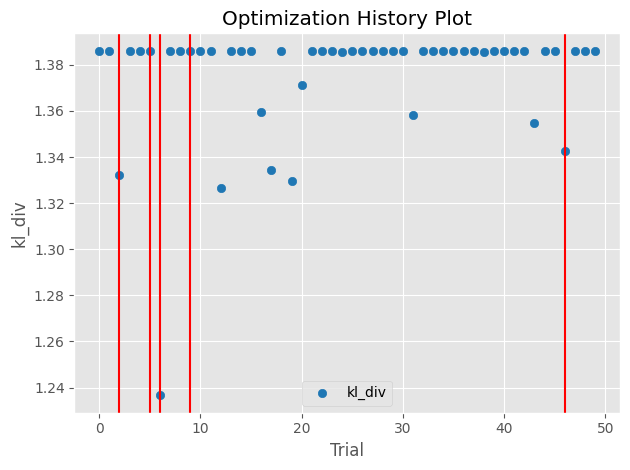

In [45]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(
    opt_trial.study, target=lambda t: t.values[0], target_name="kl_div"
)
for t in opt_trial.study.best_trials:
    plt.axvline(t.number, color="red")
# plt.axvline(nash_trial.number, color="orange")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_24723/740841843.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(


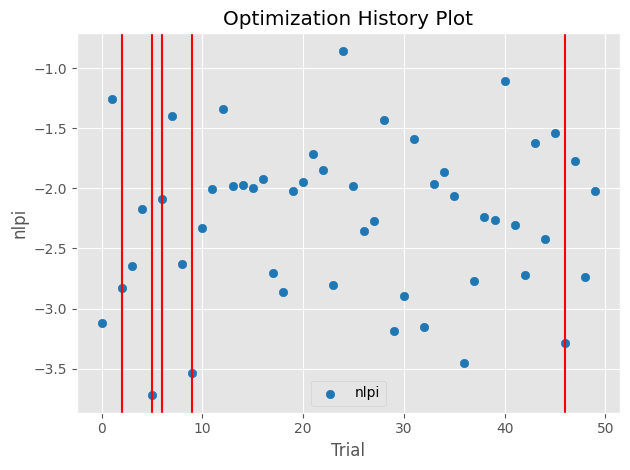

In [46]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(
    opt_trial.study, target=lambda t: t.values[1], target_name="nlpi"
)
for t in opt_trial.study.best_trials:
    plt.axvline(t.number, color="red")
# plt.axvline(nash_trial.number, color="orange")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [47]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs["ws"])

nan 45.64190829042661
nan 55.762930001011874
nan 20.77894277501854
nan 239.26425473660058
nan 5.429709439366519


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_24723/261318559.py:4: RuntimeWarning: invalid value encountered in log
  print(np.log(vals).sum(), t.user_attrs["ws"])


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.
[1.3324041861051936, -2.831987148123365]


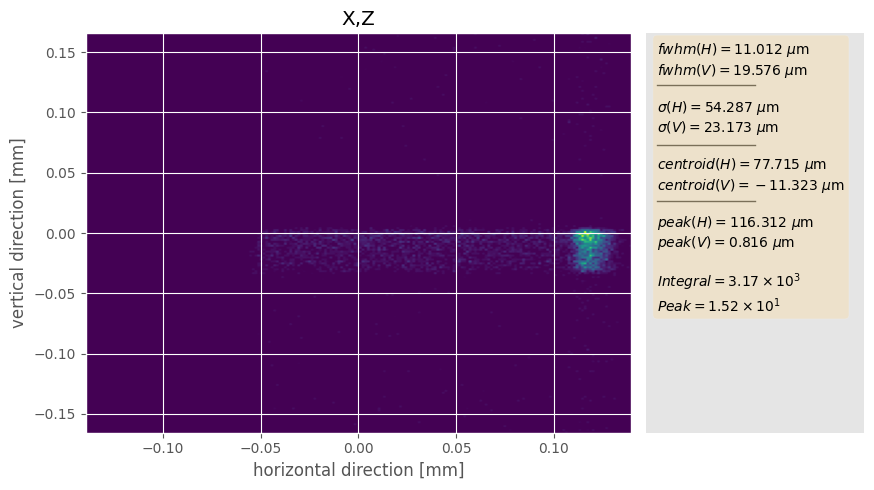

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.
[1.3861922461434537, -3.722191120535468]


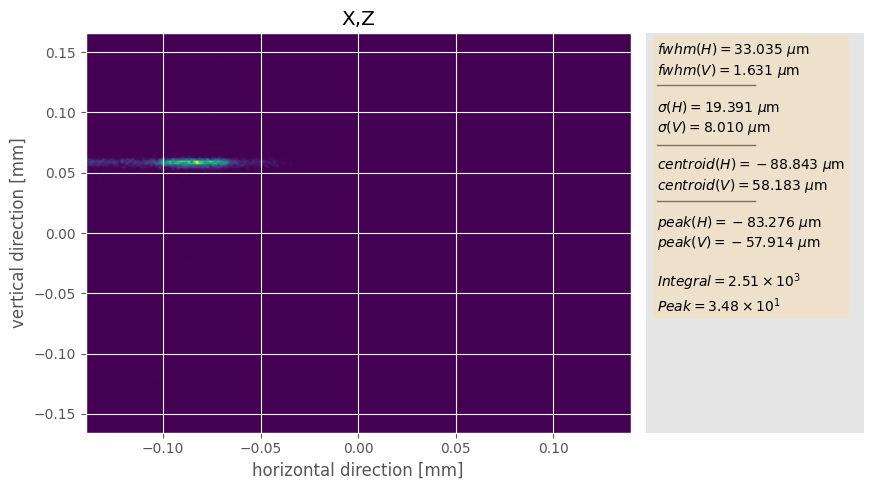

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.
[1.2365710266155023, -2.0886214426912124]


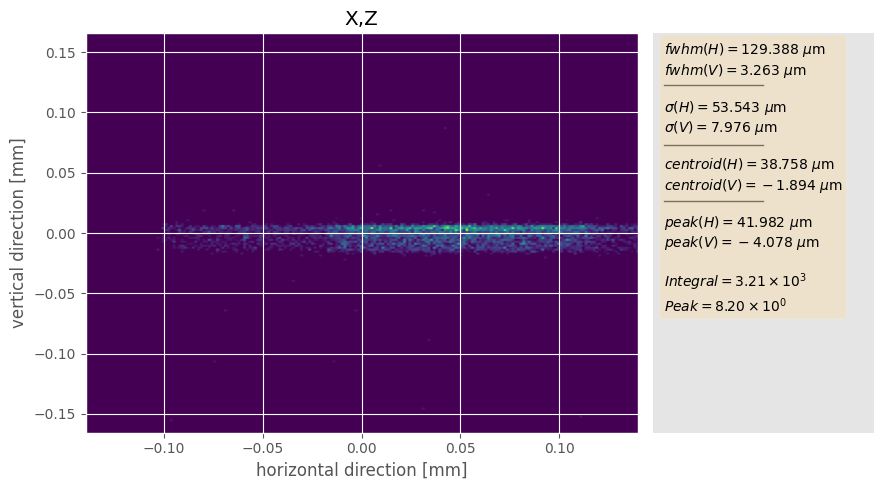

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.
[1.386125584549296, -3.5334194280208497]


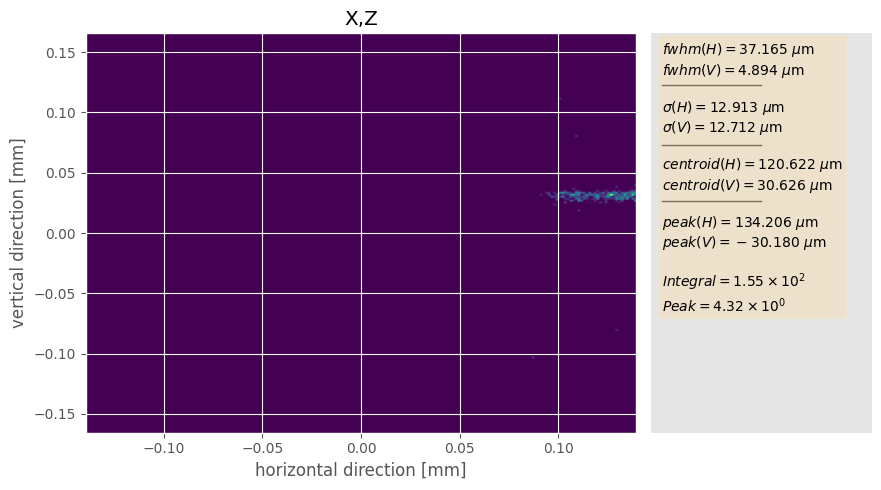

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.
[1.3425333789445306, -3.2873649321056595]


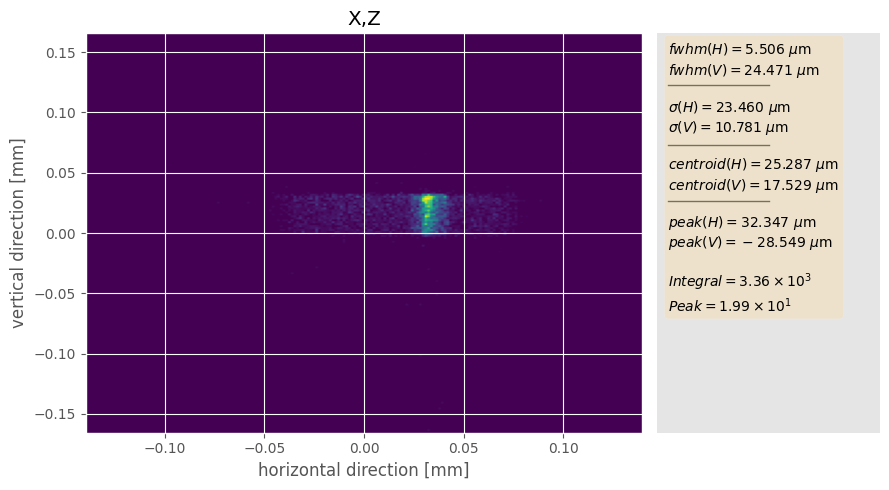

In [48]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)

    opt_common.plot_distribution(photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)
    # plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    # print(vals)
    # plt.figure(figsize=[5, 5])
    # plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    # plt.axis("off")
    # plt.show()

[1.3425333789445306, -3.2873649321056595]


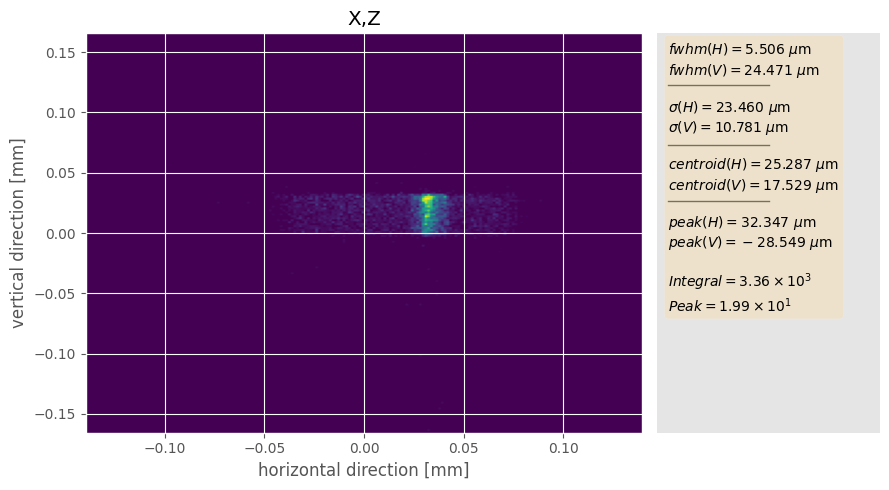

In [49]:
params, values = opt_trial.select_best_trial_params(
    opt_trial.study.best_trials, algorithm=opt_common.SelectionAlgorithm.NASH_EQUILIBRIUM
)
current_params = []
for mot in params:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(values)

opt_common.plot_distribution(photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)

#### KL Divergence removing noise, with larger fwhm

In [50]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement="absolute")

In [51]:
cp

CalculationParameters(execution_mode=0, implementor=0, xrange=[-0.7020000000000001, 0.7020000000000001], yrange=[-0.8320000000000001, 0.8320000000000001], nbins_h=1024, nbins_v=1024, do_gaussian_fit=False, use_denoised=False, from_raw_image=True, random_seed=111, add_noise=True, noise=0.5, percentage_fluctuation=50, calculate_over_noise=True, noise_threshold=1.5, reference_h=0.0, reference_v=0.0, save_images=False, every_n_images=5)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


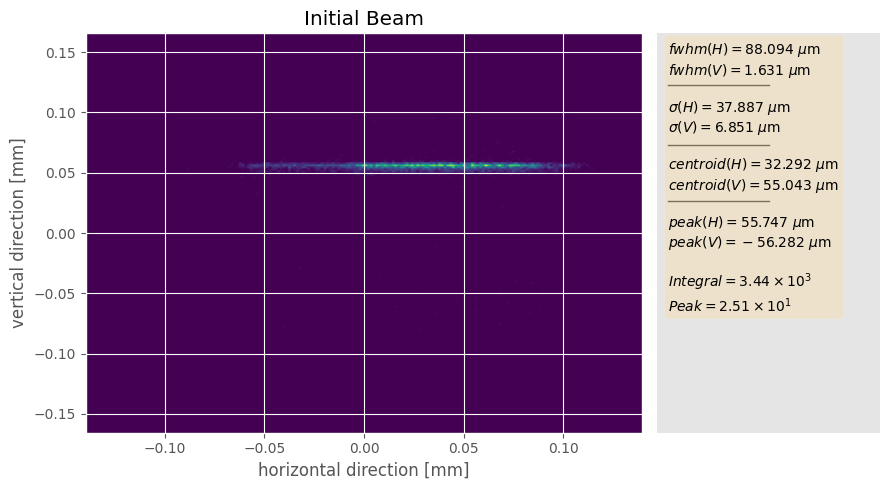

In [52]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam_pert, title="Initial Beam", ppm=ppm)

In [53]:
attribs_init = print_beam_attributes(cp, opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system kl_divergence: 1.386e+00
Perturbed beam system negative_log_peak_intensity: -3.121e+00


In [54]:
opt_params = OptimizationParameters()

In [55]:
# Now the optimization
opt_trial = OptunaOptimizer(
    calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    reference_parameters_h_v={"fwhm": (10e-3, 10e-3)},
)

In [56]:
moo_thresholds = None
if opt_params.params["multi_objective_optimization"]:
    moo_thresholds = opt_params.params["moo_thresholds"]
    for ltype in opt_params.params["loss_parameters"]:
        if ltype not in moo_thresholds:
            moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [57]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds,
)

[I 2023-05-23 16:51:40,465] A new study created in memory with name: no-name-7c74ff6c-589e-419e-9bc4-d3a4ed407490


In [58]:
opt_trial.trials(50)  # , trial_motor_types=['hb_pitch', 'hb_trans', 'vb_pitch', 'vb_trans'])

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(
[I 2023-05-23 16:51:49,072] Trial 0 finished with values: [1.3858257595533494, -3.1265278250778072] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': 0.0, 'vb_bender': 0.0, 'vb_pitch': 0.0, 'vb_trans': 0.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:51:57,734] Trial 1 finished with values: [1.3857628086747023, -1.215249217759602] and parameters: {'hb_1': 6.0, 'hb_2': -17.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': 0.016100000000000003, 'vb_bender': -8.0, 'vb_pitch': -0.00142, 'vb_trans': -0.0287}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:52:06,223] Trial 2 finished with values: [1.2595288350643081, -2.8268547678293188] and parameters: {'hb_1': -4.0, 'hb_2': -13.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': 0.029400000000000003, 'vb_bender': -11.0, 'vb_pitch': -0.00168, 'vb_trans': 0.010100000000000005}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:52:14,835] Trial 3 finished with values: [1.3860480257822645, -2.6471613907434826] and parameters: {'hb_1': 6.0, 'hb_2': -12.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.022899999999999997, 'vb_bender': -17.0, 'vb_pitch': 0.0016000000000000003, 'vb_trans': 0.017600000000000005}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:52:23,589] Trial 4 finished with values: [1.3860092665126003, -2.1709800656566616] and parameters: {'hb_1': 17.0, 'hb_2': 16.0, 'hb_pitch': 0.0019, 'hb_trans': 0.0046, 'vb_bender': 13.0, 'vb_pitch': -0.00031999999999999997, 'vb_trans': -0.028399999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:52:31,942] Trial 5 finished with values: [1.3861559871190858, -3.7202966002123126] and parameters: {'hb_1': -2.0, 'hb_2': -20.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.011800000000000005, 'vb_bender': 3.0, 'vb_pitch': -0.00092, 'vb_trans': 0.0299}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:52:40,782] Trial 6 finished with values: [1.0822756111101042, -2.087483647645308] and parameters: {'hb_1': -18.0, 'hb_2': 6.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': -0.005699999999999997, 'vb_bender': 9.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': -0.005999999999999998}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:52:49,105] Trial 7 finished with values: [1.3856780259668262, -1.4370373034522363] and parameters: {'hb_1': -9.0, 'hb_2': 23.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.018800000000000004, 'vb_bender': -19.0, 'vb_pitch': 0.0017600000000000003, 'vb_trans': 0.027000000000000003}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:52:57,835] Trial 8 finished with values: [1.3861174004769279, -2.6304800211362873] and parameters: {'hb_1': 16.0, 'hb_2': -1.0, 'hb_pitch': 0.0018, 'hb_trans': -0.0049999999999999975, 'vb_bender': -7.0, 'vb_pitch': -0.00194, 'vb_trans': -0.0278}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:53:06,629] Trial 9 finished with values: [1.3860888229032746, -3.533533050595943] and parameters: {'hb_1': -23.0, 'hb_2': -19.0, 'hb_pitch': -0.0019, 'hb_trans': -0.0165, 'vb_bender': 2.0, 'vb_pitch': -0.0013, 'vb_trans': -0.019299999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:53:22,995] Trial 10 finished with values: [1.3861133742697898, -2.3584223543776583] and parameters: {'hb_1': 22.0, 'hb_2': -17.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.026900000000000007, 'vb_bender': 19.0, 'vb_pitch': -0.00106, 'vb_trans': 0.0233}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: U

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:53:39,492] Trial 11 finished with values: [1.385834127062626, -1.9930811429480344] and parameters: {'hb_1': -25.0, 'hb_2': -9.0, 'hb_pitch': 0.0009000000000000002, 'hb_trans': -0.024399999999999998, 'vb_bender': -5.0, 'vb_pitch': -0.00023999999999999998, 'vb_trans': 0.005600000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/o

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:53:54,468] Trial 12 finished with values: [1.2268310626448373, -1.3575586104891852] and parameters: {'hb_1': -5.0, 'hb_2': 5.0, 'hb_pitch': 0.0005, 'hb_trans': -0.014799999999999999, 'vb_bender': -20.0, 'vb_pitch': -0.0003399999999999998, 'vb_trans': 0.021500000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:54:11,844] Trial 13 finished with values: [1.3860151056078625, -1.9751623029263] and parameters: {'hb_1': 3.0, 'hb_2': -25.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': -0.0032999999999999974, 'vb_bender': -14.0, 'vb_pitch': 0.00168, 'vb_trans': 0.005500000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:54:29,740] Trial 14 finished with values: [1.3859591094823054, -1.944509672590349] and parameters: {'hb_1': 4.0, 'hb_2': 7.0, 'hb_pitch': -0.0016, 'hb_trans': 0.025800000000000003, 'vb_bender': 16.0, 'vb_pitch': -0.0009399999999999999, 'vb_trans': 0.004300000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:54:48,059] Trial 15 finished with values: [1.3859566140512314, -2.026840396426354] and parameters: {'hb_1': 0.0, 'hb_2': -6.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': 0.028900000000000002, 'vb_bender': 14.0, 'vb_pitch': 0.0014600000000000004, 'vb_trans': 0.008400000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optun

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:55:05,380] Trial 16 finished with values: [1.326432500550958, -1.9121565751636758] and parameters: {'hb_1': -22.0, 'hb_2': -1.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': -0.012799999999999999, 'vb_bender': -13.0, 'vb_pitch': 0.00068, 'vb_trans': -0.009799999999999996}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distrib

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:55:22,415] Trial 17 finished with values: [1.2468356429534222, -2.6953612678519403] and parameters: {'hb_1': 22.0, 'hb_2': 10.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': 0.0267, 'vb_bender': 15.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': 0.009100000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:55:39,078] Trial 18 finished with values: [1.3860381636174206, -2.8634612012715404] and parameters: {'hb_1': -7.0, 'hb_2': -17.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': 0.026500000000000003, 'vb_bender': -10.0, 'vb_pitch': -0.0012799999999999999, 'vb_trans': 0.015300000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:55:56,486] Trial 19 finished with values: [1.2458557989168748, -2.051724672565872] and parameters: {'hb_1': -12.0, 'hb_2': 20.0, 'hb_pitch': -0.00039999999999999996, 'hb_trans': 0.0182, 'vb_bender': 8.0, 'vb_pitch': 0.0017400000000000002, 'vb_trans': -0.0165}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: U

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:56:13,016] Trial 20 finished with values: [1.3499230149904295, -1.9432586485893892] and parameters: {'hb_1': -22.0, 'hb_2': 3.0, 'hb_pitch': -0.0012000000000000001, 'hb_trans': 0.0006000000000000033, 'vb_bender': -9.0, 'vb_pitch': -0.0004599999999999999, 'vb_trans': 0.0030000000000000027}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:56:28,772] Trial 21 finished with values: [1.3858022217656145, -1.6761956619057221] and parameters: {'hb_1': -1.0, 'hb_2': 6.0, 'hb_pitch': 0.0002999999999999999, 'hb_trans': -0.028999999999999998, 'vb_bender': -16.0, 'vb_pitch': -0.00098, 'vb_trans': 0.021300000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distribut

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:56:45,987] Trial 22 finished with values: [1.3855705279067545, -1.8349032948501118] and parameters: {'hb_1': 25.0, 'hb_2': -17.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.023399999999999997, 'vb_bender': -9.0, 'vb_pitch': -0.00027999999999999987, 'vb_trans': 0.020700000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-package

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:57:05,750] Trial 23 finished with values: [1.3860482006365704, -2.7842505451477053] and parameters: {'hb_1': -6.0, 'hb_2': -18.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.026600000000000006, 'vb_bender': 10.0, 'vb_pitch': -0.002, 'vb_trans': -0.016599999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:57:22,853] Trial 24 finished with values: [1.3845584768790278, -0.8383613178340827] and parameters: {'hb_1': -11.0, 'hb_2': -2.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.011199999999999998, 'vb_bender': -11.0, 'vb_pitch': -0.00152, 'vb_trans': 0.0187}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701:

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:57:39,504] Trial 25 finished with values: [1.3859058484484201, -1.9830517918790966] and parameters: {'hb_1': -13.0, 'hb_2': -7.0, 'hb_pitch': -0.0005, 'hb_trans': 0.0039000000000000007, 'vb_bender': -17.0, 'vb_pitch': -0.00019999999999999987, 'vb_trans': -0.016399999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:57:57,070] Trial 26 finished with values: [1.3859148124032934, -2.336563470837625] and parameters: {'hb_1': -12.0, 'hb_2': -9.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.016600000000000004, 'vb_bender': -19.0, 'vb_pitch': 0.0018000000000000004, 'vb_trans': -0.0208}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distribut

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:58:15,128] Trial 27 finished with values: [1.386055760386338, -2.2781784207416744] and parameters: {'hb_1': 22.0, 'hb_2': -4.0, 'hb_pitch': 0.0015, 'hb_trans': -0.0286, 'vb_bender': 20.0, 'vb_pitch': 8.000000000000021e-05, 'vb_trans': -0.0278}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The 

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:58:32,672] Trial 28 finished with values: [1.385880486551516, -1.4135009817006552] and parameters: {'hb_1': -23.0, 'hb_2': 6.0, 'hb_pitch': -0.0015, 'hb_trans': -0.0215, 'vb_bender': 19.0, 'vb_pitch': -0.0003399999999999998, 'vb_trans': 0.015100000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: Us

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:58:50,396] Trial 29 finished with values: [1.3861490550121833, -3.1841415449142354] and parameters: {'hb_1': 10.0, 'hb_2': 2.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': -0.009499999999999998, 'vb_bender': 5.0, 'vb_pitch': 0.00068, 'vb_trans': -0.0236}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: Us

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:59:08,557] Trial 30 finished with values: [1.3860788921232934, -2.8893325207930216] and parameters: {'hb_1': -17.0, 'hb_2': 13.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': -0.003199999999999998, 'vb_bender': -2.0, 'vb_pitch': -0.00039999999999999996, 'vb_trans': -0.009599999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:59:26,528] Trial 31 finished with values: [1.3111306024398284, -1.597460321654653] and parameters: {'hb_1': -5.0, 'hb_2': 19.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.009399999999999999, 'vb_bender': 20.0, 'vb_pitch': -0.0019, 'vb_trans': 0.020700000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distribut

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 16:59:45,180] Trial 32 finished with values: [1.3860333177429118, -3.1505556794737646] and parameters: {'hb_1': -17.0, 'hb_2': -18.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.0279, 'vb_bender': -9.0, 'vb_pitch': 0.0009400000000000003, 'vb_trans': -0.0224}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: 

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 17:00:02,890] Trial 33 finished with values: [1.3858651678443796, -1.9651261151170494] and parameters: {'hb_1': -14.0, 'hb_2': -2.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': 0.009400000000000006, 'vb_bender': -15.0, 'vb_pitch': -0.00013999999999999993, 'vb_trans': -0.010899999999999996}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-package

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 17:00:20,541] Trial 34 finished with values: [1.385987571455695, -1.8754005148388844] and parameters: {'hb_1': -5.0, 'hb_2': 11.0, 'hb_pitch': 0.0019, 'hb_trans': 0.0291, 'vb_bender': -9.0, 'vb_pitch': 0.00010000000000000026, 'vb_trans': 0.029400000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: User

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 17:00:39,368] Trial 35 finished with values: [1.3829533858821195, -2.0660768391877196] and parameters: {'hb_1': -23.0, 'hb_2': 17.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': 0.026000000000000002, 'vb_bender': -5.0, 'vb_pitch': -0.00027999999999999987, 'vb_trans': 0.0077000000000000055}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-package

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 17:00:57,970] Trial 36 finished with values: [1.3861404276029257, -3.4533869782852857] and parameters: {'hb_1': -4.0, 'hb_2': -21.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': -0.0005999999999999964, 'vb_bender': -1.0, 'vb_pitch': 0.0016600000000000005, 'vb_trans': -0.0247}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distri

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 17:01:16,379] Trial 37 finished with values: [1.3837171009264462, -2.7787358262187665] and parameters: {'hb_1': -23.0, 'hb_2': -15.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': 0.023200000000000005, 'vb_bender': 18.0, 'vb_pitch': 0.0005200000000000001, 'vb_trans': 0.0172}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distribut

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 17:01:35,146] Trial 38 finished with values: [1.3776467921692632, -2.2293061770451175] and parameters: {'hb_1': -9.0, 'hb_2': -8.0, 'hb_pitch': -0.0005, 'hb_trans': -0.013699999999999997, 'vb_bender': 13.0, 'vb_pitch': 0.0015800000000000002, 'vb_trans': -0.014599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distribut

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 17:01:53,523] Trial 39 finished with values: [1.3859406055135837, -2.263990089773808] and parameters: {'hb_1': -18.0, 'hb_2': -5.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.026800000000000004, 'vb_bender': -16.0, 'vb_pitch': 0.00068, 'vb_trans': -0.0235}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: U

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 17:02:11,520] Trial 40 finished with values: [1.3857884856059102, -1.122273611620455] and parameters: {'hb_1': -8.0, 'hb_2': -16.0, 'hb_pitch': 0.0015, 'hb_trans': -0.009399999999999999, 'vb_bender': 4.0, 'vb_pitch': -0.00156, 'vb_trans': 0.012100000000000007}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: Use

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 17:02:29,226] Trial 41 finished with values: [1.3860129940829573, -2.313063086401406] and parameters: {'hb_1': 16.0, 'hb_2': 25.0, 'hb_pitch': -0.0019, 'hb_trans': -0.014299999999999997, 'vb_bender': 11.0, 'vb_pitch': 0.00046000000000000034, 'vb_trans': -0.0163}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: U

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 17:02:47,695] Trial 42 finished with values: [1.3860560805331403, -2.7181042218160405] and parameters: {'hb_1': 11.0, 'hb_2': 14.0, 'hb_pitch': -0.0014, 'hb_trans': 0.019600000000000006, 'vb_bender': -7.0, 'vb_pitch': 0.0007800000000000003, 'vb_trans': -0.015199999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 17:03:04,910] Trial 43 finished with values: [1.3164340313150478, -1.6263915017816817] and parameters: {'hb_1': -21.0, 'hb_2': 20.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': 0.025300000000000003, 'vb_bender': -15.0, 'vb_pitch': -0.0009599999999999999, 'vb_trans': -0.000499999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-package

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 17:03:23,761] Trial 44 finished with values: [1.3860625675213567, -2.400698254494067] and parameters: {'hb_1': 6.0, 'hb_2': 1.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': -0.0005999999999999964, 'vb_bender': 10.0, 'vb_pitch': -0.00192, 'vb_trans': -0.0254}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: U

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 17:03:41,473] Trial 45 finished with values: [1.3859089941588716, -1.537906866274315] and parameters: {'hb_1': -1.0, 'hb_2': 20.0, 'hb_pitch': 0.0018, 'hb_trans': 0.0033000000000000043, 'vb_bender': -19.0, 'vb_pitch': -0.0018, 'vb_trans': 0.027200000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: Use

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 17:03:59,807] Trial 46 finished with values: [1.283314339841416, -3.2850353420929572] and parameters: {'hb_1': 8.0, 'hb_2': -15.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': -0.003199999999999998, 'vb_bender': 14.0, 'vb_pitch': 0.0019000000000000002, 'vb_trans': 0.0092}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 17:04:19,047] Trial 47 finished with values: [1.3817946496521596, -1.807798193754864] and parameters: {'hb_1': -10.0, 'hb_2': 21.0, 'hb_pitch': -0.0009, 'hb_trans': -0.005199999999999996, 'vb_bender': -10.0, 'vb_pitch': 0.00042000000000000023, 'vb_trans': -0.010099999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distrib

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 17:04:37,459] Trial 48 finished with values: [1.3861206507104908, -2.7473786288777187] and parameters: {'hb_1': -18.0, 'hb_2': 4.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': -0.0208, 'vb_bender': 3.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': 0.0262}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: Us

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-05-23 17:04:56,433] Trial 49 finished with values: [1.3860219984329603, -2.000103716280226] and parameters: {'hb_1': -11.0, 'hb_2': 15.0, 'hb_pitch': -0.0009, 'hb_trans': -0.021599999999999998, 'vb_bender': 10.0, 'vb_pitch': 0.0005, 'vb_trans': 0.008}. 


In [59]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    print(np.log(vals).sum(), t.user_attrs["ws"])

nan 46.01000225664086
nan 55.849279929592655
nan 20.812195921833013
nan 241.50362243551734
nan 9.683898935860293
nan 5.424471780019939


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_24723/261318559.py:4: RuntimeWarning: invalid value encountered in log
  print(np.log(vals).sum(), t.user_attrs["ws"])


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.
[1.2595288350643081, -2.8268547678293188]


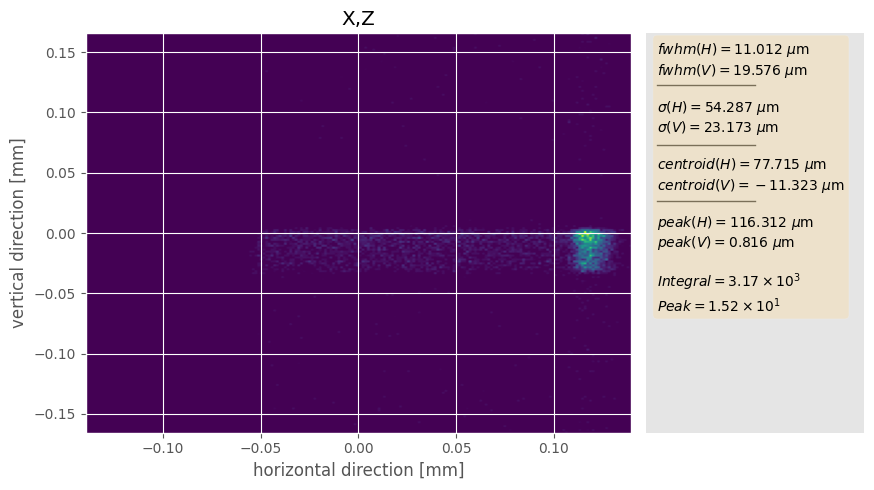

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.
[1.3861559871190858, -3.7202966002123126]


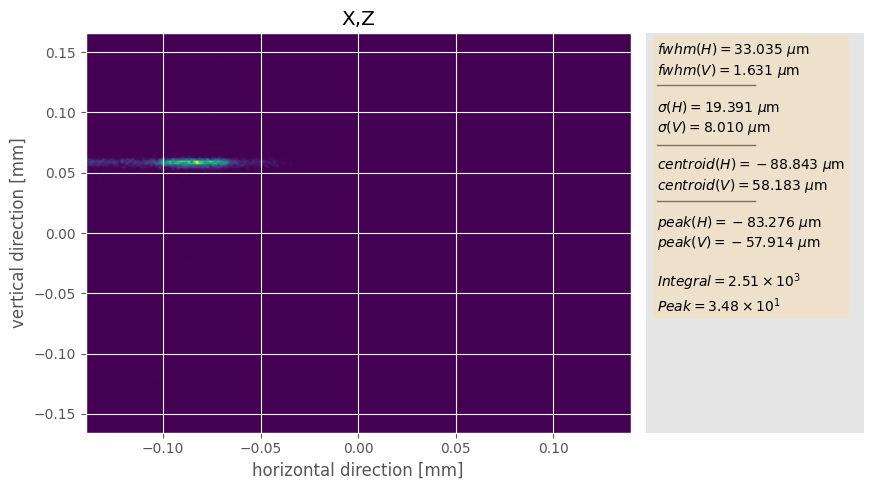

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.
[1.0822756111101042, -2.087483647645308]


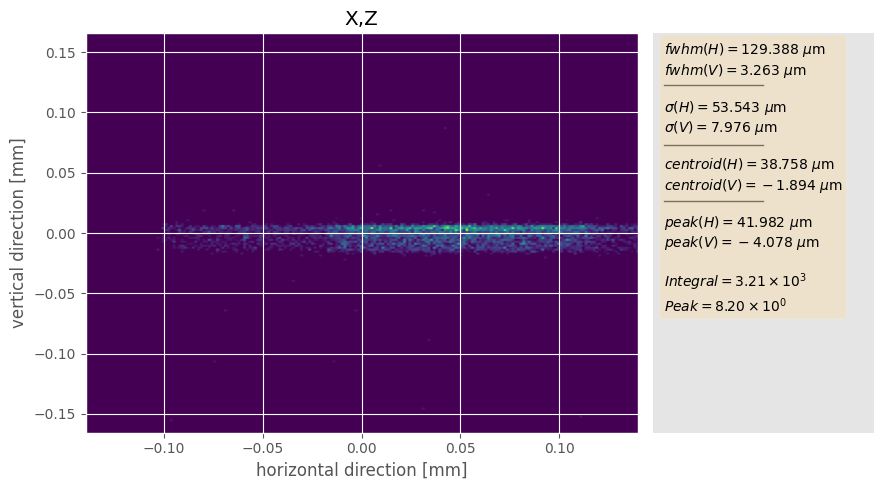

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.
[1.3860888229032746, -3.533533050595943]


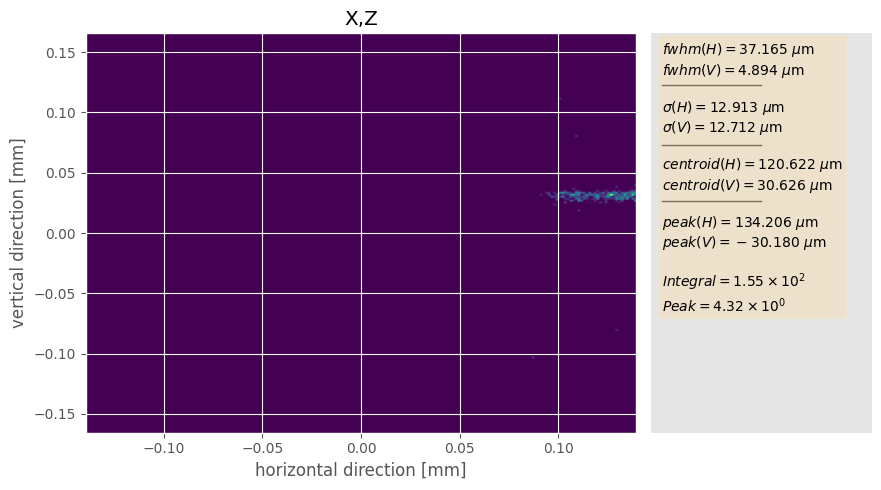

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.
[1.2468356429534222, -2.6953612678519403]


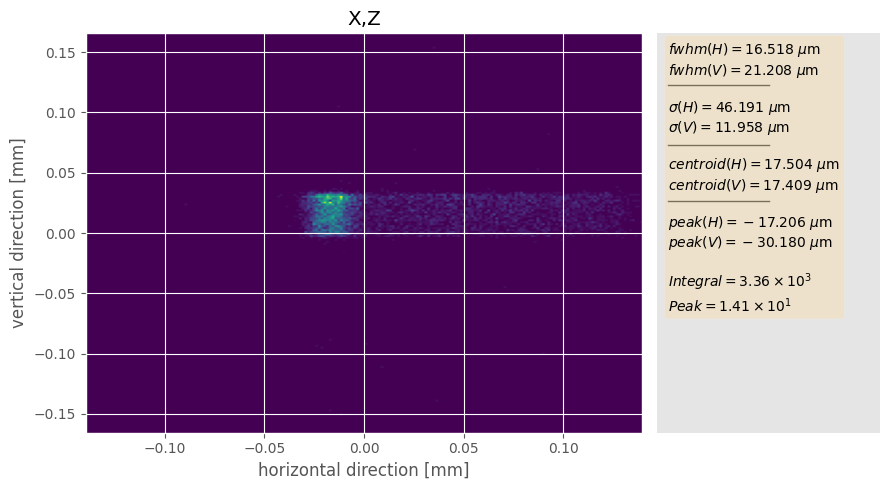

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/work_dir_38449/Downstream_HKB_bender_profile.dat written to disk.
[1.283314339841416, -3.2850353420929572]


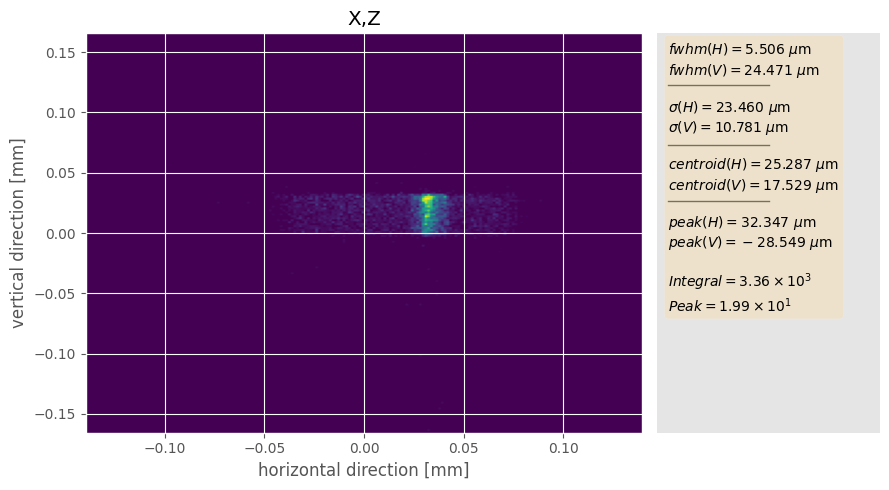

In [60]:
for t in opt_trial.study.best_trials:
    params = t.params
    vals = t.values
    current_params = []
    for mot in opt_trial.motor_types:
        current_params.append(params[mot])
    opt_trial._loss_fn_this(current_params)
    print(t.values)

    opt_common.plot_distribution(photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)
    # plot_shadow_beam_spatial_distribution(opt_trial.beam_state.photon_beam, xrange=opt_trial._camera_xrange, yrange=opt_trial._camera_yrange)
    # print(vals)
    # plt.figure(figsize=[5, 5])
    # plt.imshow(opt_trial.beam_state.hist.data_2D[700:-700,700:-700])
    # plt.axis("off")
    # plt.show()

[1.283314339841416, -3.2850353420929572]


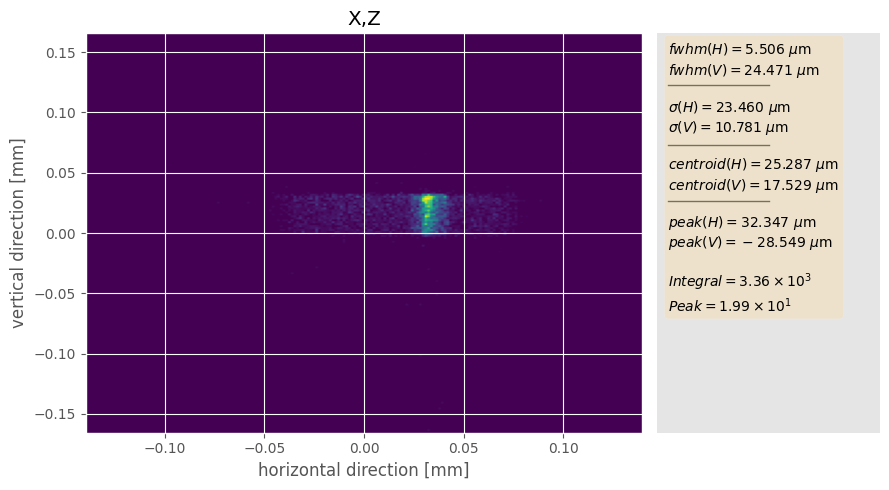

In [61]:
params, values = opt_trial.select_best_trial_params(
    opt_trial.study.best_trials, algorithm=opt_common.SelectionAlgorithm.NASH_EQUILIBRIUM
)
current_params = []
for mot in params:
    current_params.append(params[mot])
opt_trial._loss_fn_this(current_params)
print(values)

opt_common.plot_distribution(photon_beam=opt_trial.beam_state.photon_beam, ppm=ppm)